# Description

In this project, we will be predicting a full year worth of sales for various fictitious learning modules from different fictitious Kaggle-branded stores in different (real!) countries. This dataset is completely synthetic, but contains many effects you see in real-world data, e.g., weekend and holiday effect, seasonality, etc. You are given the task of predicting sales during for year 2022.

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
ordinal_encoder = OrdinalEncoder()
country_label_encoder = LabelEncoder()
store_label_encoder = LabelEncoder()
product_label_encoder = LabelEncoder()
data = pd.read_csv("/kaggle/input/playground-series-s3e19/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e19/test.csv")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        136950 non-null  int64 
 1   date      136950 non-null  object
 2   country   136950 non-null  object
 3   store     136950 non-null  object
 4   product   136950 non-null  object
 5   num_sold  136950 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 6.3+ MB


In [28]:
test.head()

id        date    country         store  \
0  136950  2022-01-01  Argentina  Kaggle Learn   
1  136951  2022-01-01  Argentina  Kaggle Learn   
2  136952  2022-01-01  Argentina  Kaggle Learn   
3  136953  2022-01-01  Argentina  Kaggle Learn   
4  136954  2022-01-01  Argentina  Kaggle Learn   

                                          product  
0               Using LLMs to Improve Your Coding  
1                   Using LLMs to Train More LLMs  
2  Using LLMs to Win Friends and Influence People  
3      Using LLMs to Win More Kaggle Competitions  
4                      Using LLMs to Write Better

In [29]:
data.head()

id        date    country         store  \
0   0  2017-01-01  Argentina  Kaggle Learn   
1   1  2017-01-01  Argentina  Kaggle Learn   
2   2  2017-01-01  Argentina  Kaggle Learn   
3   3  2017-01-01  Argentina  Kaggle Learn   
4   4  2017-01-01  Argentina  Kaggle Learn   

                                          product  num_sold  
0               Using LLMs to Improve Your Coding        63  
1                   Using LLMs to Train More LLMs        66  
2  Using LLMs to Win Friends and Influence People         9  
3      Using LLMs to Win More Kaggle Competitions        59  
4                      Using LLMs to Write Better        49

In [30]:
data['date'] = pd.to_datetime(data['date'])
test['date'] = pd.to_datetime(test['date'])

In [31]:
print(data['date'].min())
print(data['date'].max())

2017-01-01 00:00:00
2021-12-31 00:00:00


In [32]:
print(test['date'].min())
print(test['date'].max())

2022-01-01 00:00:00
2022-12-31 00:00:00


In [33]:
data['date'].value_counts()

2017-01-01    75
2020-05-11    75
2020-05-09    75
2020-05-08    75
2020-05-07    75
              ..
2018-08-29    75
2018-08-28    75
2018-08-27    75
2018-08-26    75
2021-12-31    75
Name: date, Length: 1826, dtype: int64

In [34]:
data[data['date'] == '2017-01-01'][data['product'] == 'Using LLMs to Improve Your Coding']

id       date    country         store                            product  \
0    0 2017-01-01  Argentina  Kaggle Learn  Using LLMs to Improve Your Coding   
5    5 2017-01-01  Argentina  Kaggle Store  Using LLMs to Improve Your Coding   
10  10 2017-01-01  Argentina     Kagglazon  Using LLMs to Improve Your Coding   
15  15 2017-01-01     Canada  Kaggle Learn  Using LLMs to Improve Your Coding   
20  20 2017-01-01     Canada  Kaggle Store  Using LLMs to Improve Your Coding   
25  25 2017-01-01     Canada     Kagglazon  Using LLMs to Improve Your Coding   
30  30 2017-01-01    Estonia  Kaggle Learn  Using LLMs to Improve Your Coding   
35  35 2017-01-01    Estonia  Kaggle Store  Using LLMs to Improve Your Coding   
40  40 2017-01-01    Estonia     Kagglazon  Using LLMs to Improve Your Coding   
45  45 2017-01-01      Japan  Kaggle Learn  Using LLMs to Improve Your Coding   
50  50 2017-01-01      Japan  Kaggle Store  Using LLMs to Improve Your Coding   
55  55 2017-01-01      Japan     Kagglazon  Using LLMs to Improve Your Coding   
60  60 2017-01-01      Spain  Kaggle Learn  Using LLMs to Improve Your Coding   
65  65 2017-01-01      Spain  Kaggle Store  Using LLMs to Improve Your Coding   
70  70 2017-01-01      Spain     Kagglazon  Using LLMs to Improve Your Coding   

    num_sold  
0         63  
5         88  
10       340  
15       202  
20       274  
25      1041  
30        92  
35       132  
40       501  
45       167  
50       270  
55       938  
60       122  
65       177  
70       724

In [35]:
countries = sorted(list(set(data['country'])))
products = sorted(list(set(data['product'])))
stores = sorted(list(set(data['store'])))

<Axes: >

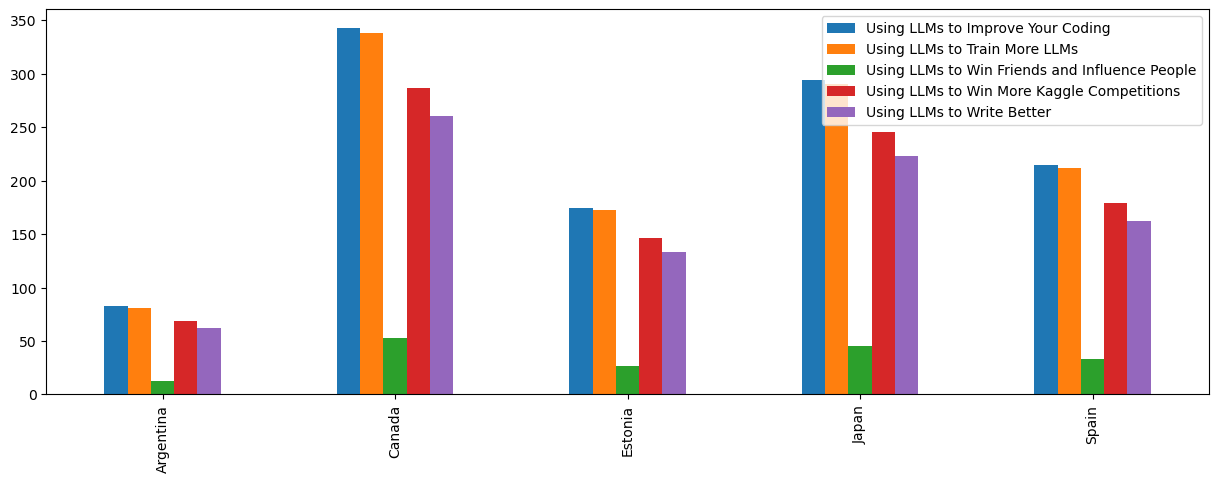

In [36]:
col = 'country'
res = pd.DataFrame(data[[col,'product','num_sold']].groupby([col,'product']).mean().values.reshape(len(countries),len(products)), columns=products).set_index([countries])
fig, ax = plt.subplots(figsize=(15, 5))
res.plot(kind='bar', ax=ax)

# from above grapah we can conclude that, for each country product sales is different

<Axes: >

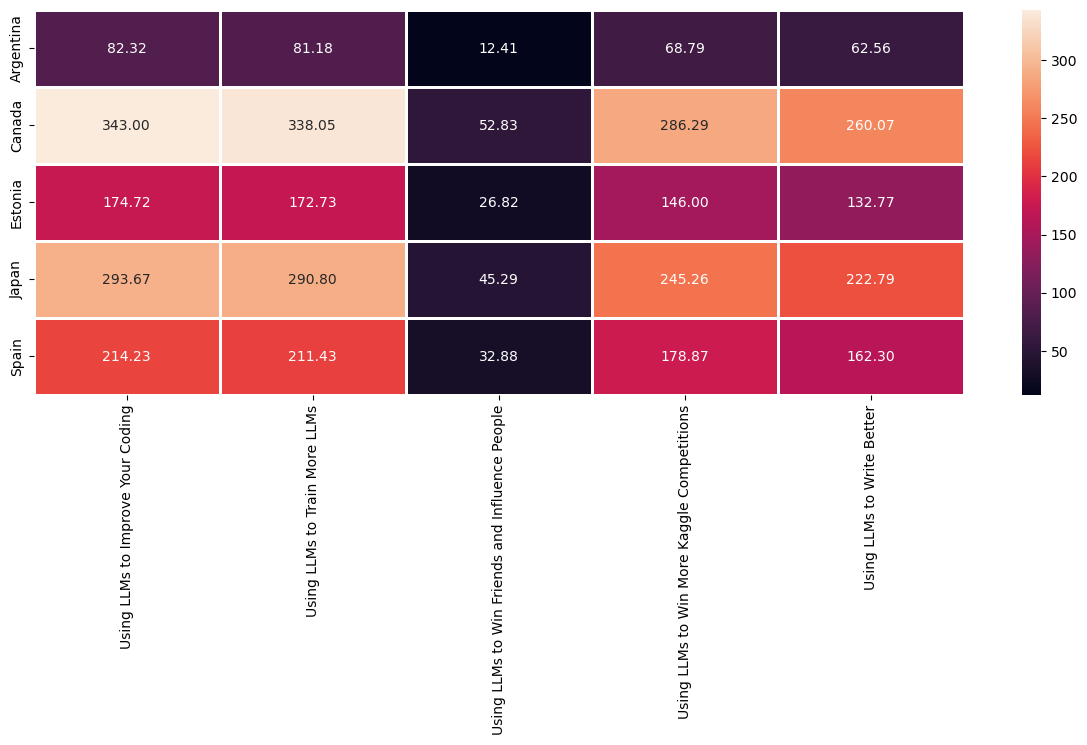

In [37]:
plt.figure(figsize=(15,5))
sns.heatmap(res, annot=True, fmt='.2f', linewidth=1)

# from above grapah it is clearly evedent that canada using the products the most and then Japan

<Axes: >

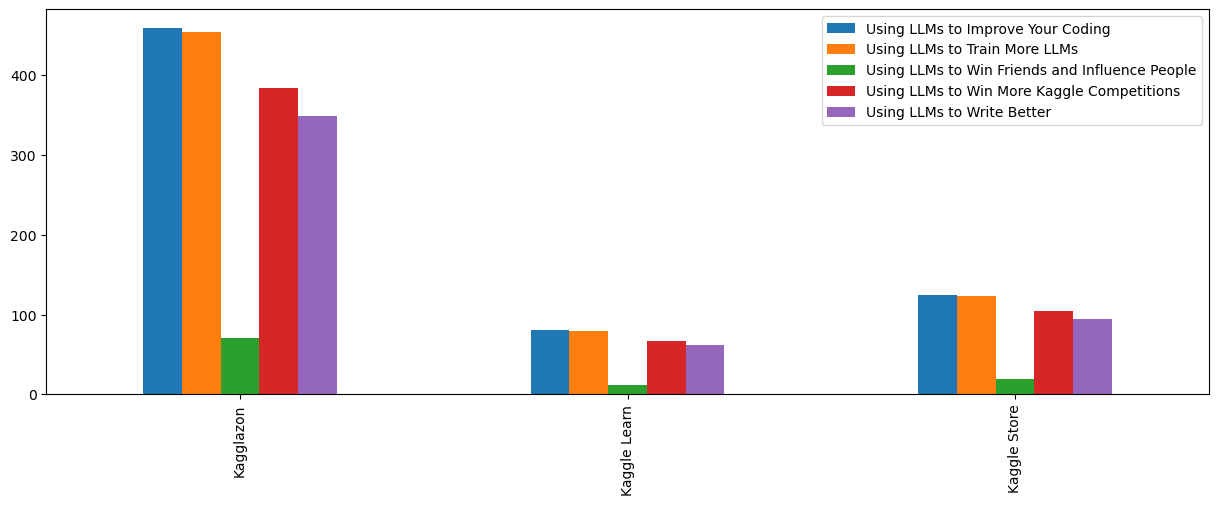

In [38]:
col = 'store'
res = pd.DataFrame(data[[col,'product','num_sold']].groupby([col,'product']).mean().values.reshape(len(stores),len(products)), columns=products).set_index([stores])
fig, ax = plt.subplots(figsize=(15, 5))
res.plot(kind='bar', ax=ax)

# Product sales in each store is different

<Axes: >

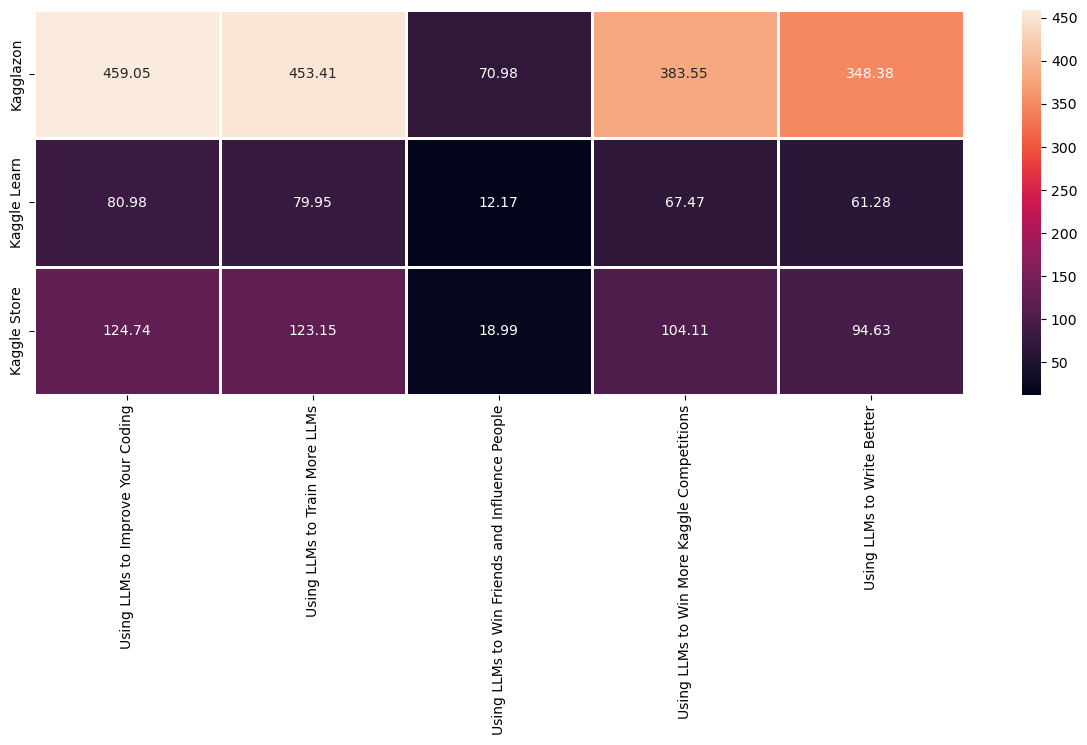

In [39]:
plt.figure(figsize=(15,5))
sns.heatmap(res, annot=True, fmt='.2f', linewidth=1)

# Kagglazon store has the highest sales accross each product

Kaggle Learn    45650
Kaggle Store    45650
Kagglazon       45650
Name: store, dtype: int64


<Axes: >

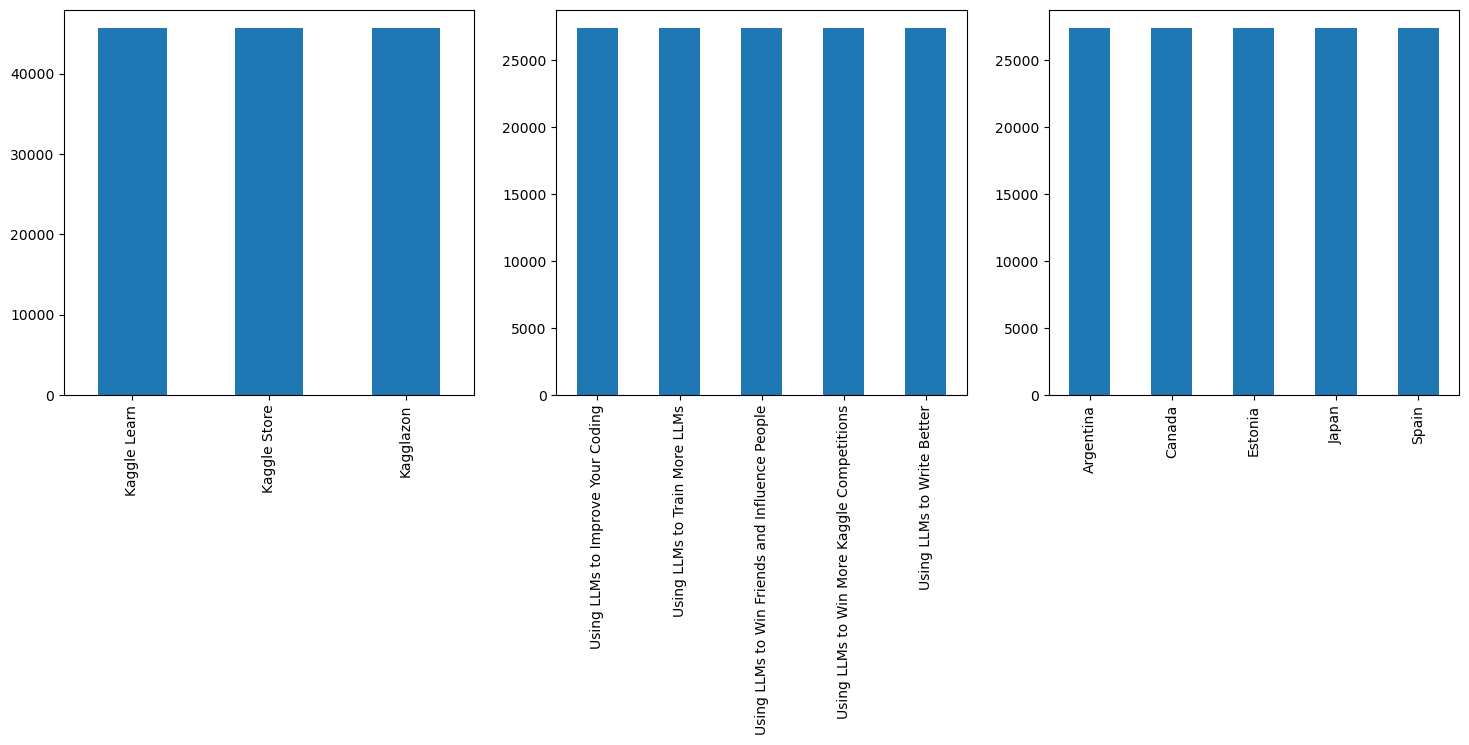

In [40]:
print(data['store'].value_counts())
fig,ax = plt.subplots(1,3, figsize=(18,5))
data['store'].value_counts().plot(kind='bar', ax=ax[0])
data['product'].value_counts().plot(kind='bar', ax=ax[1])
data['country'].value_counts().plot(kind='bar', ax=ax[2])

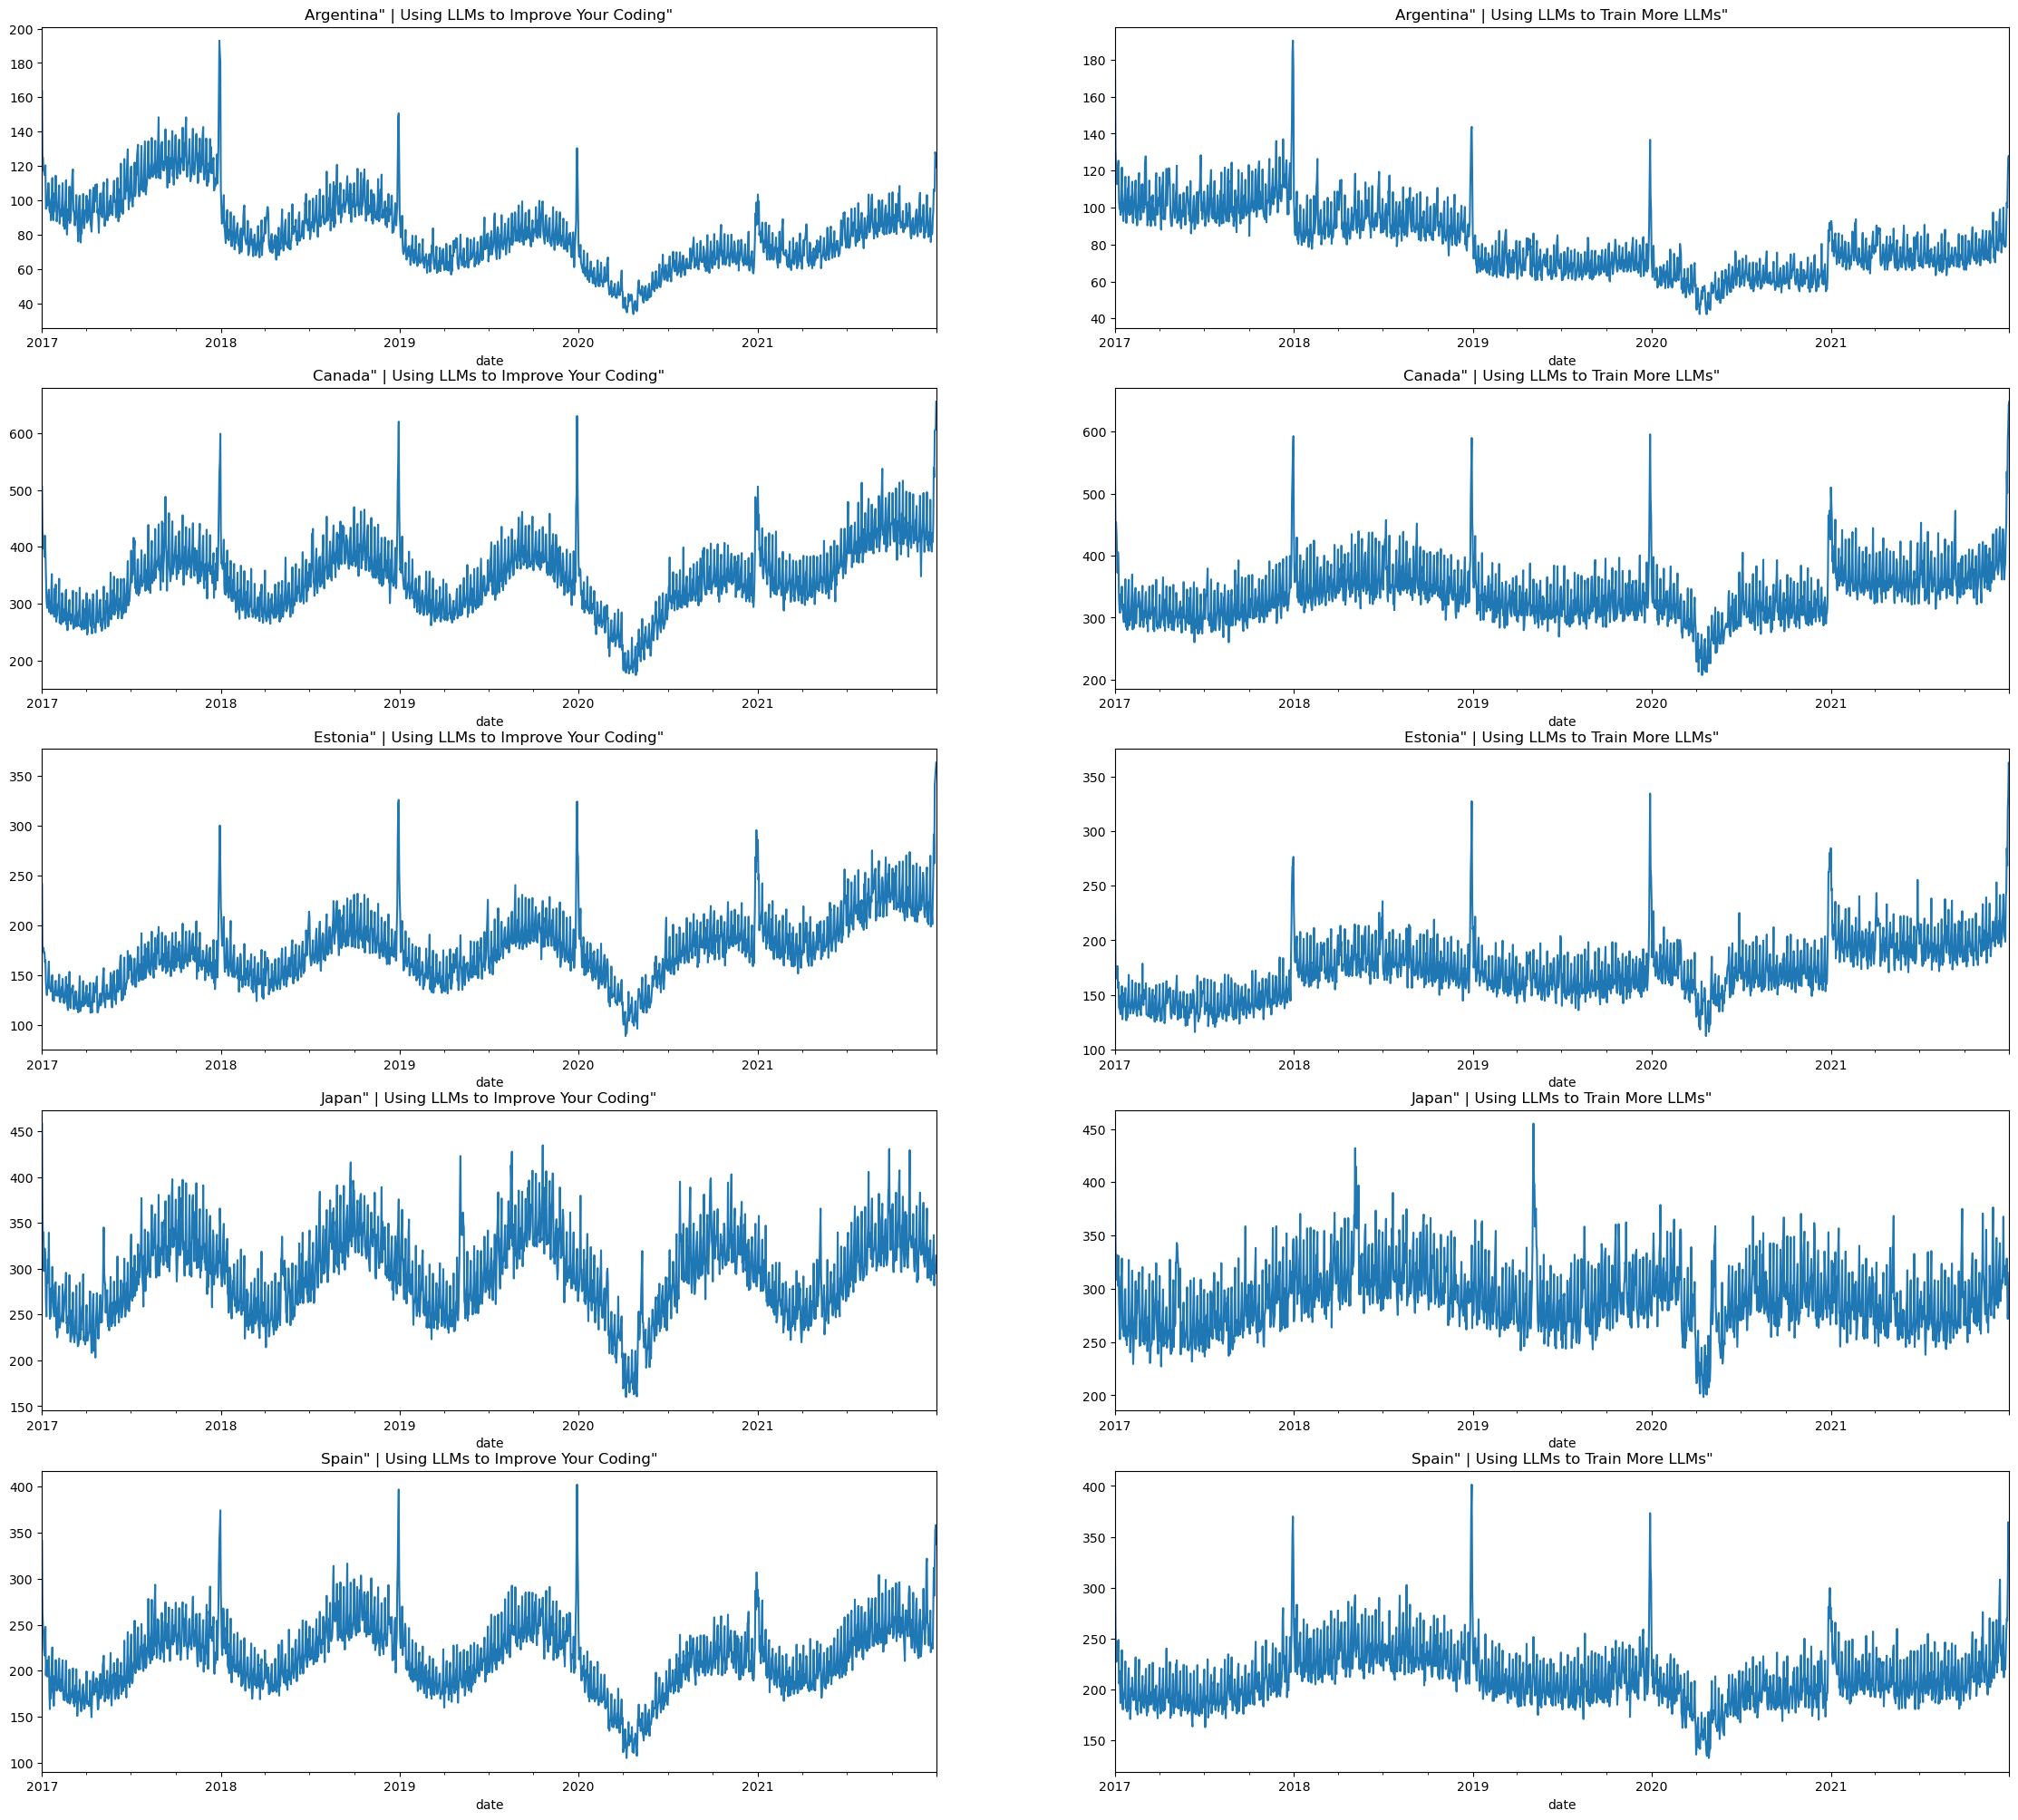

In [41]:
fig,ax = plt.subplots(len(countries),2, figsize=(28,25))
i=0
for c in countries:
    j=0
    for p in products[:2]:
        df = data[(data['country'] == c) & (data['product'] == p)][['date','num_sold']].groupby('date').mean()
        df['num_sold'].plot(ax=ax[i,j])
        ax[i,j].set_title(f'{c}" | {p}"')
        #sns.lineplot(x=df['date'],y=df['num_sold'] ,linewidth=1,ci=None,ax=ax)
        j=j+1
    i=i+1
            
plt.show()

# In above graph, we can clearly observe yearly pattern in selling. To be clear, i have again plotted few products below from different stores. Note that year 2020 has little different selling behaviour. it might be because of covid situation

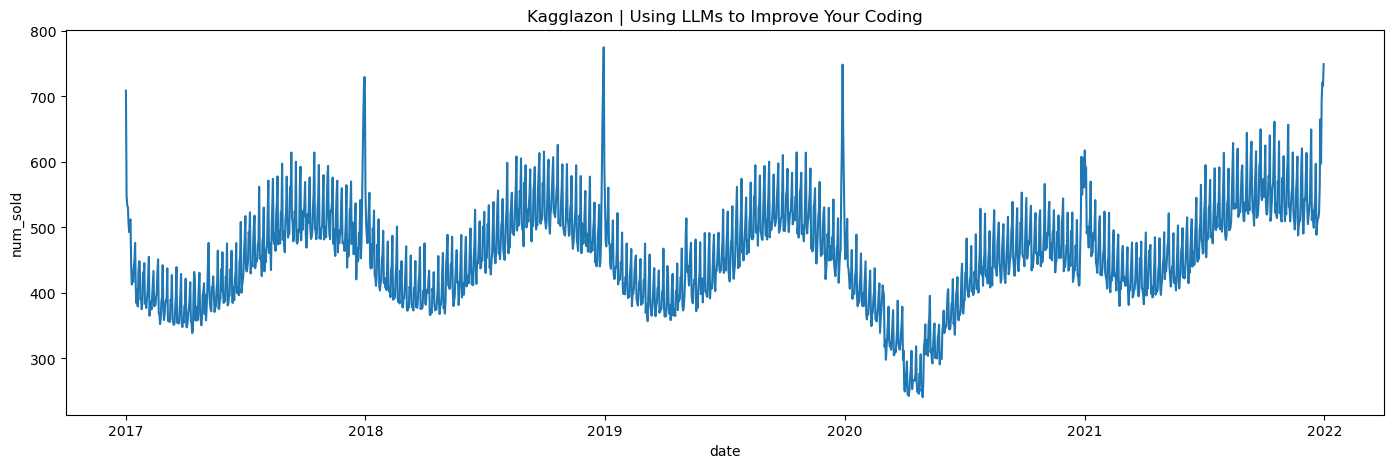

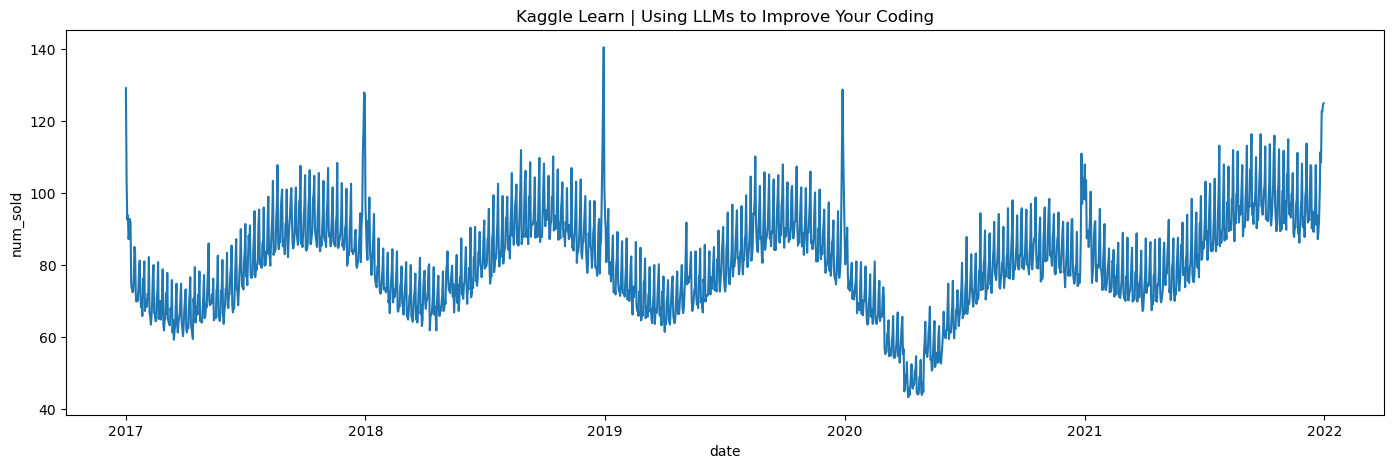

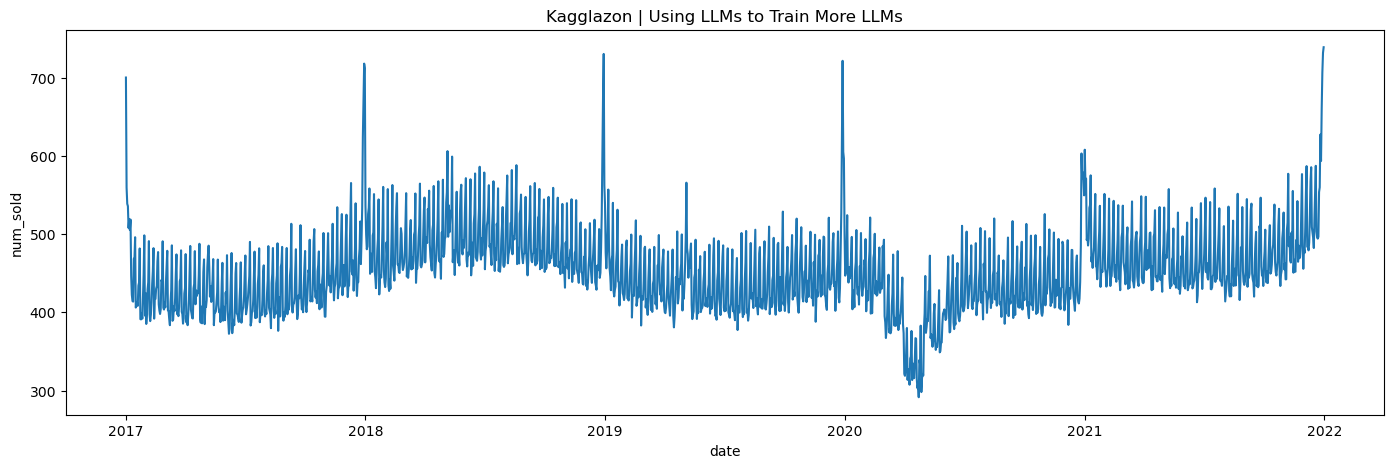

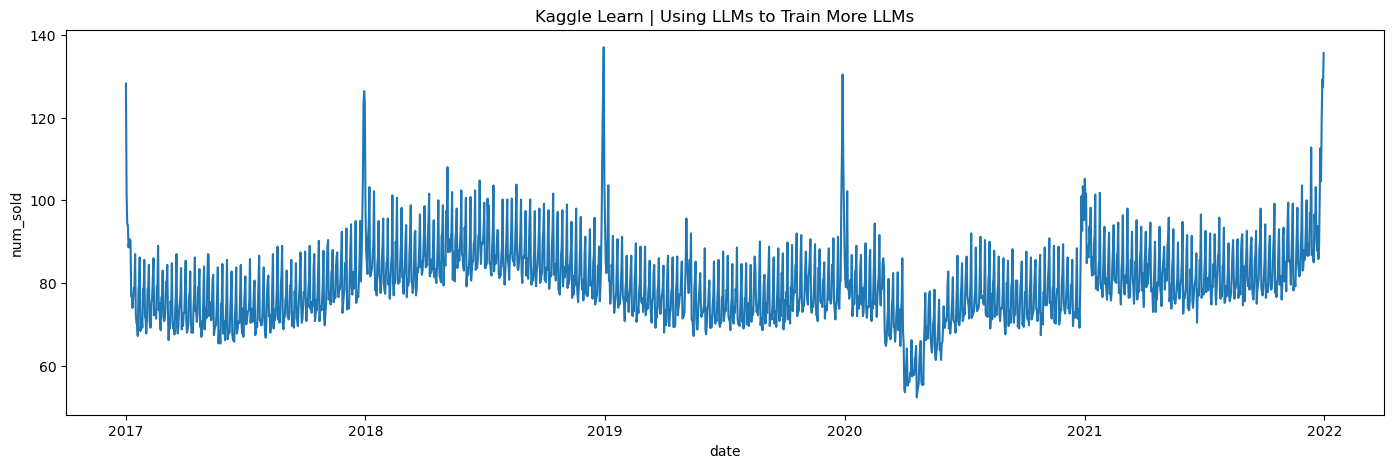

In [42]:
col = ['date','product','store','country','num_sold']
for product in products[:2]:
    for store in stores[:2]:
        plt.figure(figsize=(17,5))
        df = data[data['product'] == product][data['store'] == store][col].groupby('date').mean()
        sns.lineplot(x='date',y='num_sold',ci=None, data=df)
        plt.title(f"{store} | {product}")
        plt.show()

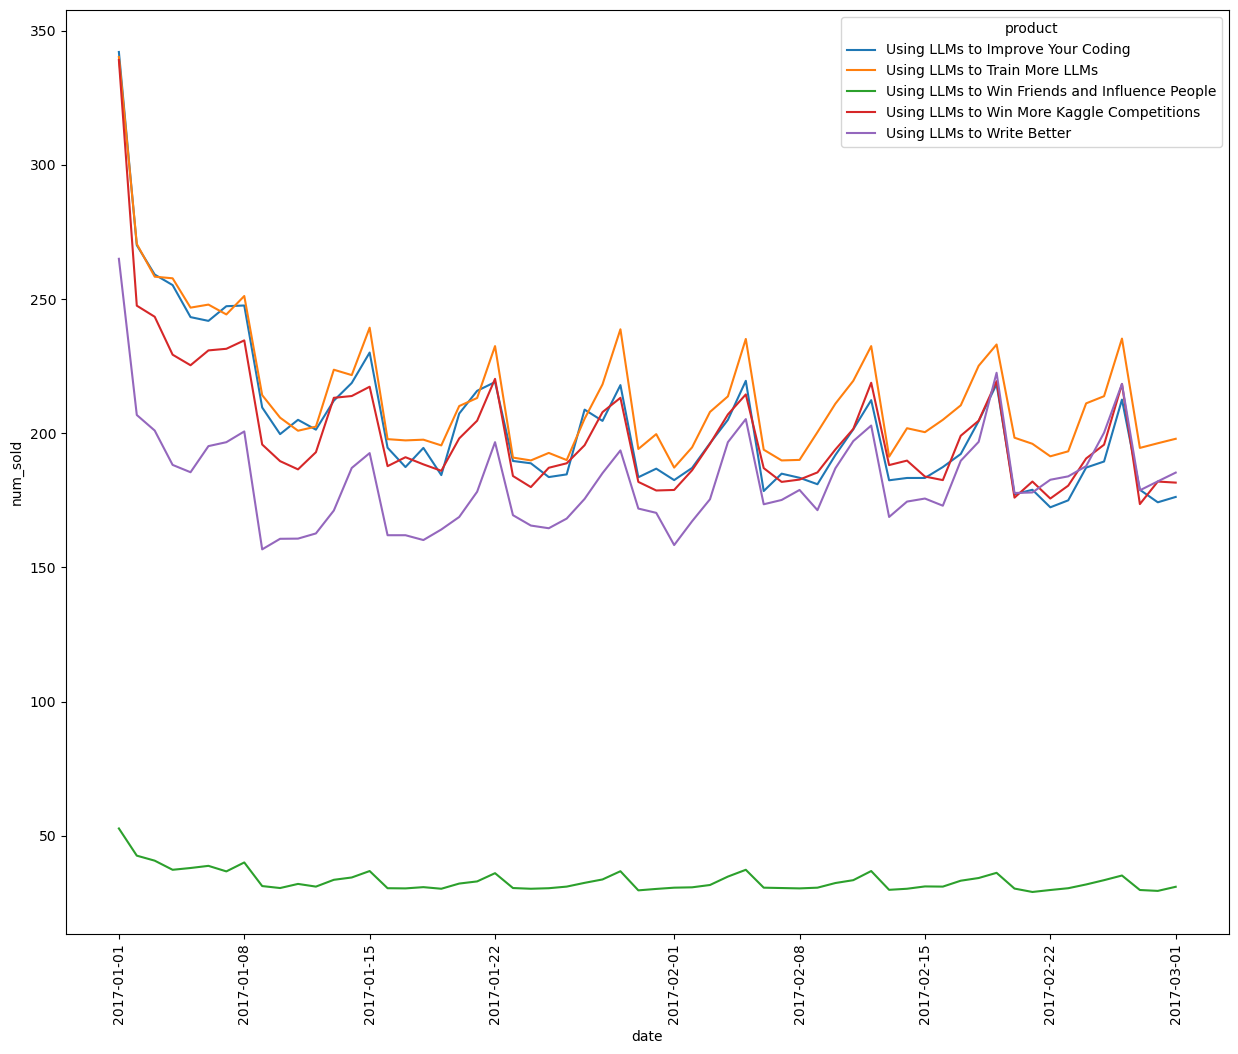

In [43]:
df = data.copy()
    
start = '2017-01-01'
end = '2017-03-01'

fig,ax = plt.subplots(figsize=(15,12))
temp_dff = df[['num_sold','date','product']][(df['date'] >= start) & (df['date'] <= end)].groupby(['date','product']).mean().reset_index()
#print(temp_dff)
sns.lineplot(x='date', y='num_sold', hue='product', data=temp_dff, ci=None)
plt.xticks(rotation=90)
plt.show()

# DATA Also shows weekly pattern. lets verify the same using PACF plot for a perticular product

# But before applying PACF, we will have to make data stationary if it is not already. We will use adfuller hypothesis testing to check if the data is stationary.

# with adfuller hypothesis test:
# H0:  Data is not stationary
# H1:  Data is stationary

In [44]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
int_data = data[(data['country']=='Argentina') & (data['store']=='Kaggle Learn') &  (data['product']=='Using LLMs to Improve Your Coding')]['num_sold']

adfuller(int_data)

(-1.661765270838378,
 0.45091194580391397,
 25,
 1800,
 {'1%': -3.4339881389288407,
  '5%': -2.863147035877915,
  '10%': -2.567625533641975},
 8380.006897141702)

# P-vlues(2nd element) is .45, which means, data is not stationary. Now to make it stationary, we will apply differencing

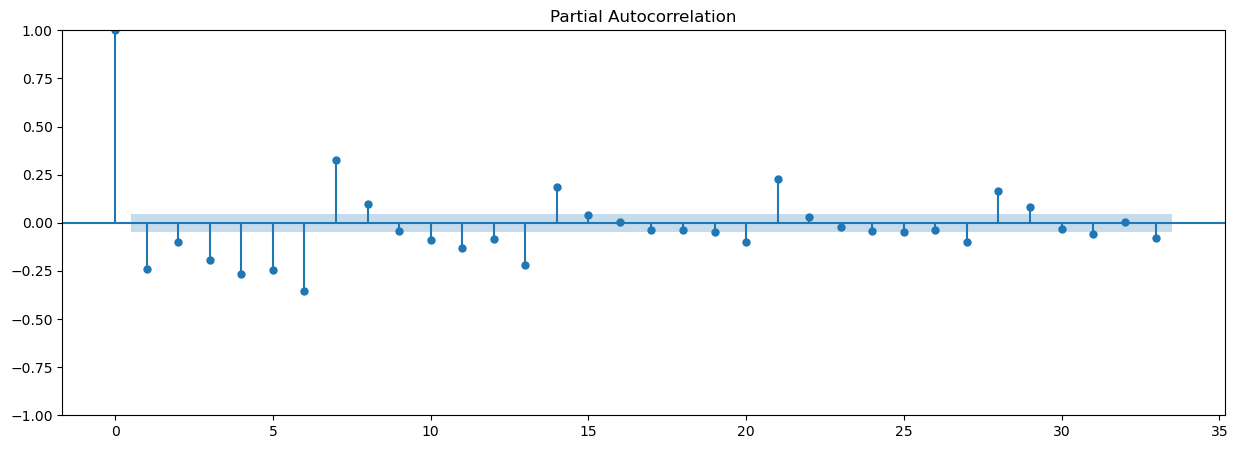

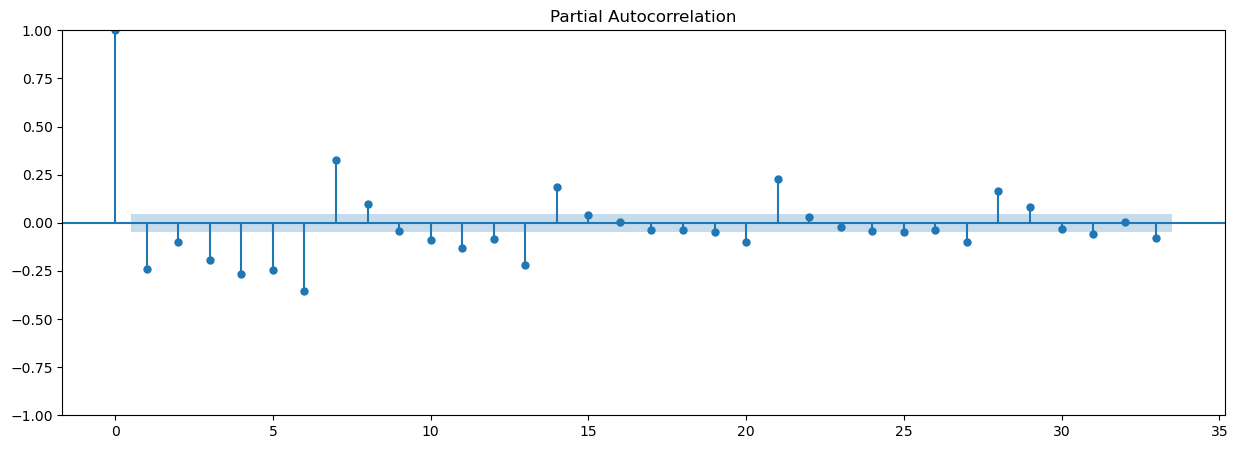

In [45]:
int_data = data[(data['country']=='Argentina') & (data['store']=='Kaggle Learn') &  (data['product']=='Using LLMs to Improve Your Coding')]['num_sold'].diff().dropna()
fig,ax = plt.subplots(figsize=(15,5))
plot_pacf(int_data, ax=ax)

# PACF seems to show that data indeed has weekly pattern

# DATA PREPARATION AND MODEL BUILDING

# Below functions are responsible for creating lag varibales and other feature engineering realted to timeseries

# Also i am creating moving avarage faetures for certain periods with exponential decay. Doing this will give more weightage to most recent selling behaviour

In [147]:
countries = sorted(list(set(data['country'])))
products = sorted(list(set(data['product'])))
stores = sorted(list(set(data['store'])))
alpha  = 0.02
def create_time_series_faetures(df, lag=7):
    if 'date' in df.columns:
        df = df.set_index('date')
    # Calculate the first-order difference of the sales data
    df['differencing'] = df['num_sold'].diff().shift(1)
    for i in [14,30,90]:
        df['Rolling_Mean_{}'.format(i)] = df['num_sold'].rolling(window=i).apply(lambda x: x.ewm(alpha=alpha).mean().iloc[-1]).shift(1)
        df['Rolling_Std_{}'.format(i)] = df['num_sold'].rolling(window=i).apply(lambda x: x.ewm(alpha=alpha).std().iloc[-1]).shift(1)
    return df


def create_lags(data, lags):
    for i in range(lags):
        data['lag_{}'.format(i+1)] = data['num_sold'].shift(i+1)    
    return data


def clreate_lags_by_group(data, lags=7):
    cols = list(data.columns)
    for i in range(lags):
        cols.append('lag_{}'.format(i+1))
    final_data = pd.DataFrame()

    for country in countries:
        for product in products:
            for store in stores:
                temp = data[(data['country'] == country) & (data['store'] == store) & (data['product'] == product)]
                lagged_data = create_lags(temp, lags) 
                #timeseries_data = create_time_series_faetures(lagged_data, lag=7)
                final_data = pd.concat([final_data,lagged_data], axis=0)
                
    
    return final_data.reset_index()

# Below function engineer few importent features that can help understanding the data in a better way

In [157]:
alpha = 0.1
def create_month_based_feature(data):
    month_data = pd.DataFrame()
    for country in countries:
        for product in products:
            for store in stores:
                temp = data[(data['country'] == country) & (data['store'] == store) & (data['product'] == product)]
                temp = temp[['country','store','product','month','num_sold']]
                #temp = temp.groupby(['country','store','product','month']).mean().reset_index().rename(columns={'num_sold':'month_avg_sold'})
                #temp = temp.groupby(['country','store','product','month']).agg({'num_sold': ['max', 'min', 'mean', 'std']})
                temp = temp.groupby(['country', 'store', 'product', 'month'])['num_sold'].agg([
                    ('mean', lambda x: x.ewm(alpha=alpha).mean().iloc[-1]),
                    ('std', lambda x: x.ewm(alpha=alpha).std().iloc[-1])
                ])
                predecessor = 'month_'
                temp.columns = [f"{predecessor}_{col}" for col in temp.columns]
                temp = temp.reset_index()
                month_data = pd.concat([month_data,temp], axis=0)
    return month_data

def create_week_based_feature(data):
    week_data = pd.DataFrame()
    for country in countries:
        for product in products:
            for store in stores:
                temp = data[(data['country'] == country) & (data['store'] == store) & (data['product'] == product)]
                temp = temp[['country','store','product','week','num_sold']]
                #temp = temp.groupby(['country','store','product','week']).mean().reset_index().rename(columns={'num_sold':'week_avg_sold'})
                #temp = temp.groupby(['country','store','product','week']).agg({'num_sold': ['max', 'min', 'mean', 'std']})
                temp = temp.groupby(['country', 'store', 'product', 'week'])['num_sold'].agg([
                    ('mean', lambda x: x.ewm(alpha=alpha).mean().iloc[-1]),
                    ('std', lambda x: x.ewm(alpha=alpha).std().iloc[-1])
                ])
                
                predecessor = 'week_'
                temp.columns = [f"{predecessor}_{col}" for col in temp.columns]
                temp = temp.reset_index()
                week_data = pd.concat([week_data,temp], axis=0)
    return week_data

def create_quarter_based_feature(data):
    quarter_data = pd.DataFrame()
    for country in countries:
        for product in products:
            for store in stores:
                temp = data[(data['country'] == country) & (data['store'] == store) & (data['product'] == product)]
                temp = temp[['country','store','product','quarter','num_sold']]
                #temp = temp.groupby(['country','store','product','quarter']).mean().reset_index().rename(columns={'num_sold':'quarter_avg_sold'})
                #temp = temp.groupby(['country','store','product','quarter']).agg({'num_sold': ['max', 'min', 'mean', 'std']})
                temp = temp.groupby(['country', 'store', 'product', 'quarter'])['num_sold'].agg([
                    ('mean', lambda x: x.ewm(alpha=alpha).mean().iloc[-1]),
                    ('std', lambda x: x.ewm(alpha=alpha).std().iloc[-1])
                ])
                predecessor = 'quarter_'
                temp.columns = [f"{predecessor}_{col}" for col in temp.columns]
                temp = temp.reset_index()
                quarter_data = pd.concat([quarter_data,temp], axis=0)
    return quarter_data



data = pd.read_csv("/kaggle/input/playground-series-s3e19/train.csv")
data['date'] = pd.to_datetime(data['date'])

data2= data.copy()
data2['year'] = data2['date'].dt.year
data2['month'] = data2['date'].dt.month
data2['quarter'] = data2['date'].dt.quarter
data2['week'] = data2['date'].dt.dayofweek

month_data = create_month_based_feature(data2)
week_data = create_week_based_feature(data2)
quarter_data = create_quarter_based_feature(data2)

In [172]:
def prepare_data(data, train_flag=False, lag_flag=False):
    if 'date' in data.columns:
        data['date'] = pd.to_datetime(data['date'])

    df = data.copy()
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['week'] = df['date'].dt.dayofweek
    #df['dayofyear'] = df['date'].dt.dayofyear
    df['day'] = df['date'].dt.day
    df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['date'].dt.dayofweek / 7)
    df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['date'].dt.dayofweek / 7)
    
    df = df.merge(month_data, on=['country','store','product','month'])
    df = df.merge(week_data, on=['country','store','product','week'])
    df = df.merge(quarter_data, on=['country','store','product','quarter'])
    
    if train_flag:
        df = df.drop(['id'], axis=1)
        #df = drop_2020(df)
        country_label_encoder.fit(df['country'])
        store_label_encoder.fit(df['store'])
        product_label_encoder.fit(df['product'])
    
    df['country'] = country_label_encoder.transform(df['country'])
    df['store'] = store_label_encoder.transform(df['store'])
    df['product'] = product_label_encoder.transform(df['product'])
    
    df = df.sort_values(by='date')
    if 'date' in df.columns:
        df = df.set_index('date')
        
    return df.dropna()

# Below is time based train test split

In [167]:
def train_test_split(int_data, train_split=0.9):
    import datetime
    #train_lim = datetime.datetime.strptime('2020-01-01','%Y-%m-%d')
    train_lim = int(len(int_data)*train_split)
    train = int_data[:train_lim]
    test = int_data[train_lim:]
    
    train_x = train.drop(['num_sold'], axis=1)
    train_y = train['num_sold']
    test_x =  test.drop(['num_sold'], axis=1)
    test_y = test['num_sold']

    return (train_x, train_y, test_x, test_y)

# Preprocess Data

In [50]:
df = prepare_data(data, train_flag=True)

In [51]:
weeks = sorted(list(set(df['week'])))
months = sorted(list(set(df['month'])))
quarters = sorted(list(set(df['quarter'])))
years = sorted(list(set(df['year'])))

# Sales by each year and month is shown below

<Axes: >

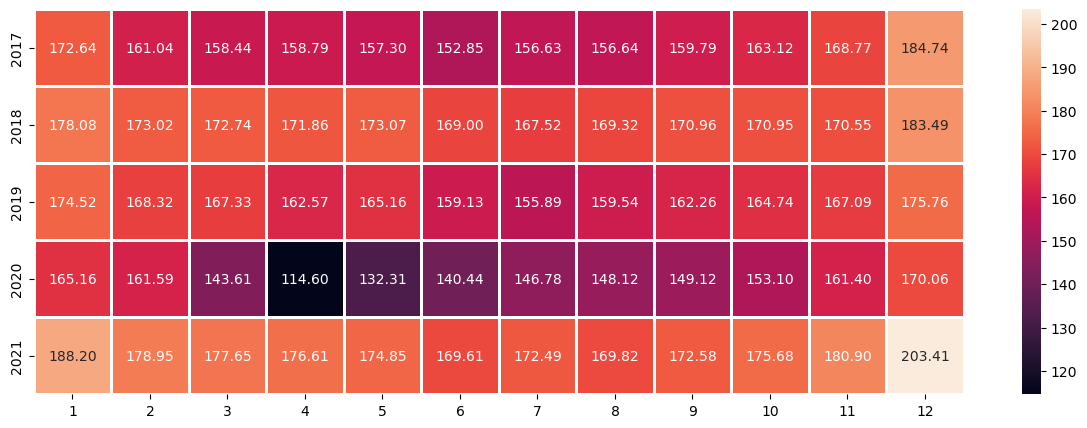

In [52]:
col = 'year'
res = pd.DataFrame(df[[col,'month','num_sold']].groupby([col,'month']).mean().values.reshape(len(years),len(months)), columns=months).set_index([years])
plt.figure(figsize=(15,5))
sns.heatmap(res, annot=True, fmt='.2f', linewidth=1)

# Product sales on different week-day

Text(0.5, 1.0, 'product sold by week')

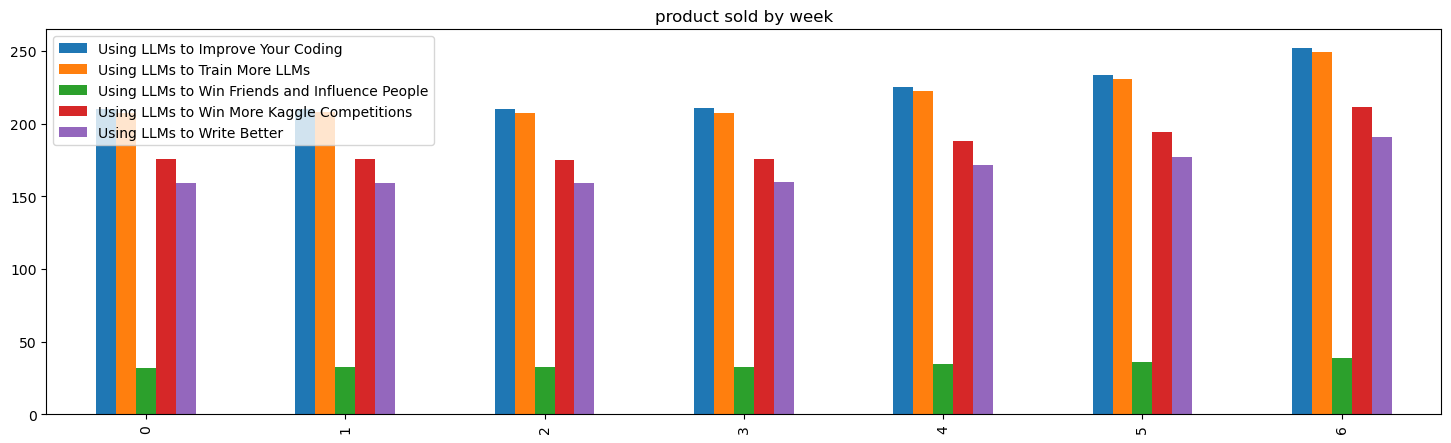

In [53]:
col = 'week'
res = pd.DataFrame(df[[col,'product','num_sold']].groupby([col,'product']).mean().values.reshape(len(weeks),len(products)), columns=products).set_index([weeks])
fig, ax = plt.subplots(figsize=(18, 5))
res.plot(kind='bar', ax=ax)
plt.title(f"product sold by {col}")

<Axes: >

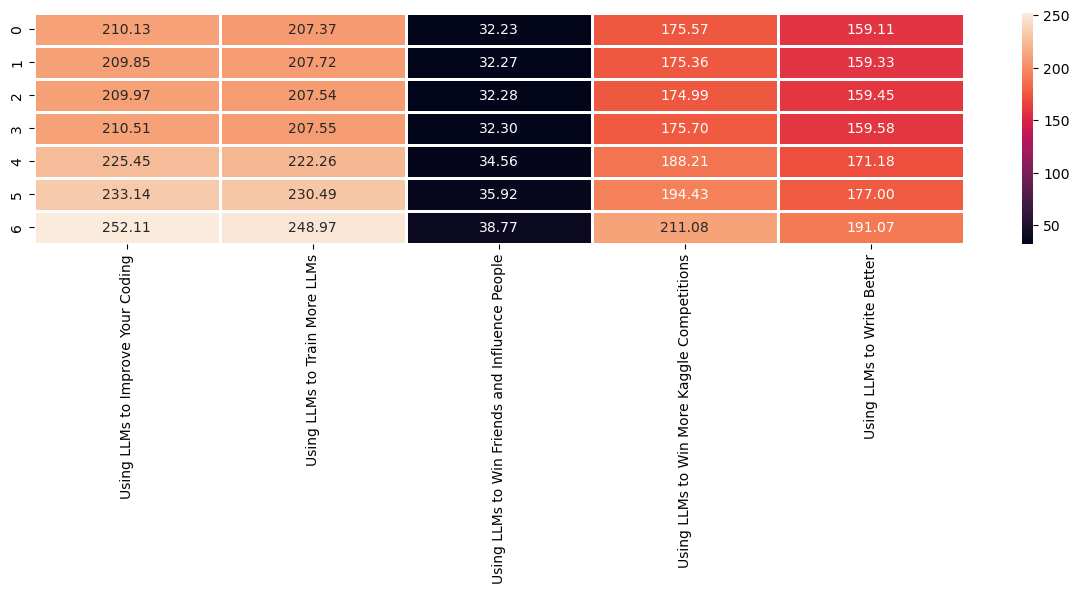

In [54]:
plt.figure(figsize=(15,3))
sns.heatmap(res, annot=True, fmt='.2f', linewidth=1)

# Above graph shows that weekday 6 has the highest sales

# product sales in each month is shown below

Text(0.5, 1.0, 'product sold by month')

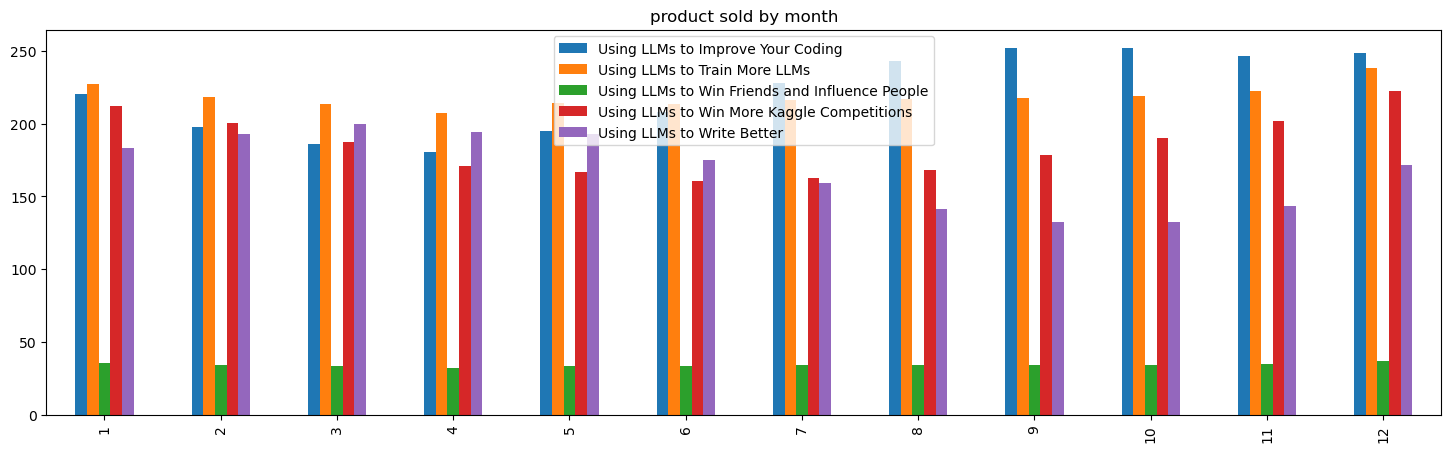

In [55]:
col = 'month'
res = pd.DataFrame(df[[col,'product','num_sold']].groupby([col,'product']).mean().values.reshape(len(months),len(products)), columns=products).set_index([months])
fig, ax = plt.subplots(figsize=(18, 5))
res.plot(kind='bar', ax=ax)
plt.title(f"product sold by {col}")

<Axes: >

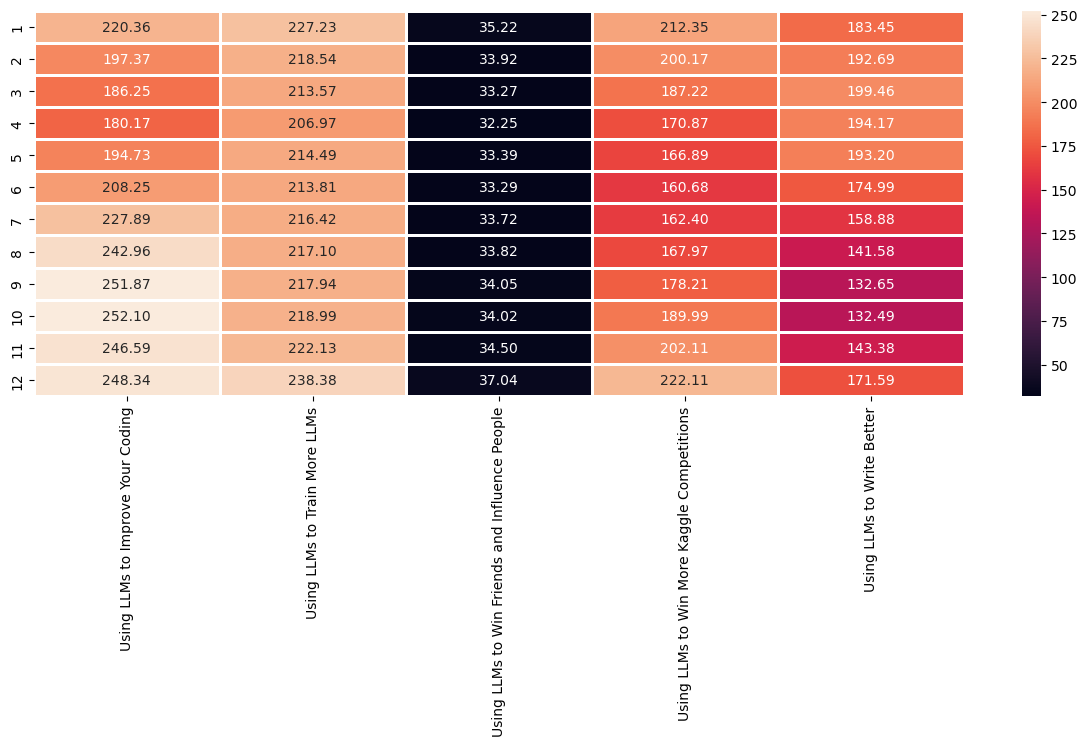

In [56]:
plt.figure(figsize=(15,5))
sns.heatmap(res, annot=True, fmt='.2f', linewidth=1)

# Product sales by quarter

Text(0.5, 1.0, 'product sold by quarter')

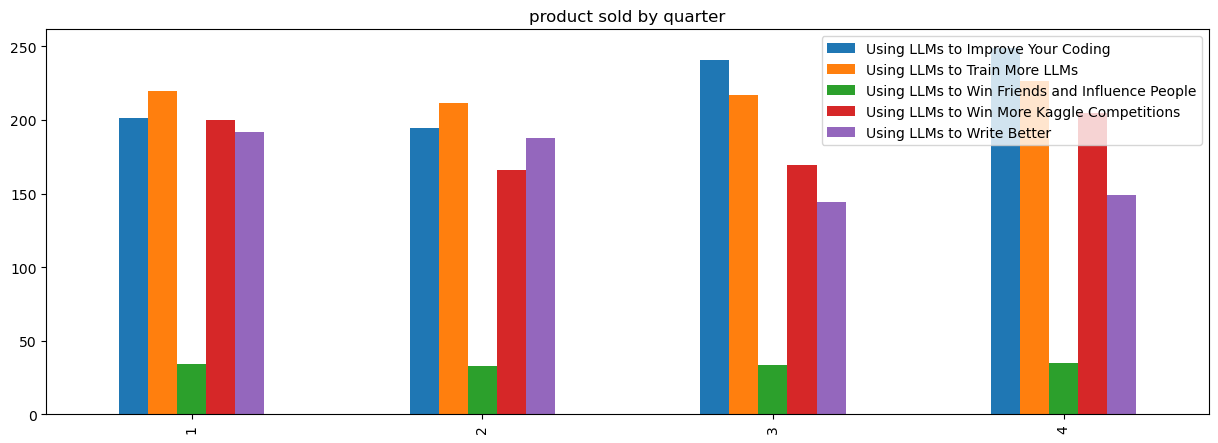

In [57]:
col = 'quarter'
res = pd.DataFrame(df[[col,'product','num_sold']].groupby([col,'product']).mean().values.reshape(len(quarters),len(products)), columns=products).set_index([quarters])
fig, ax = plt.subplots(figsize=(15, 5))
res.plot(kind='bar', ax=ax)
plt.title(f"product sold by {col}")

<Axes: >

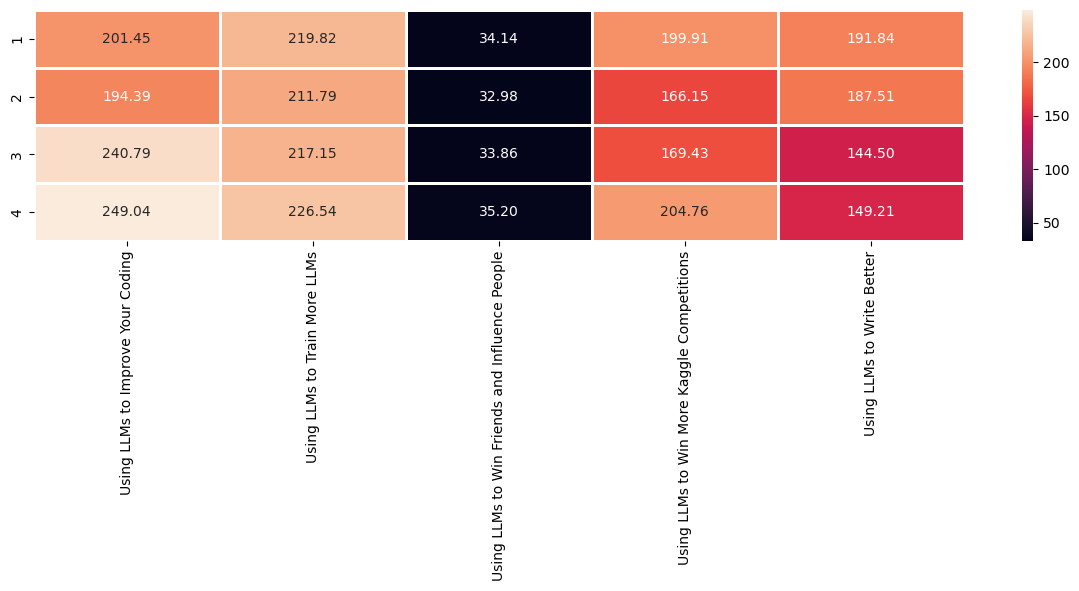

In [58]:
plt.figure(figsize=(15,3))
sns.heatmap(res, annot=True, fmt='.2f', linewidth=1)

# Product sales by Year

Text(0.5, 1.0, 'product sold by year')

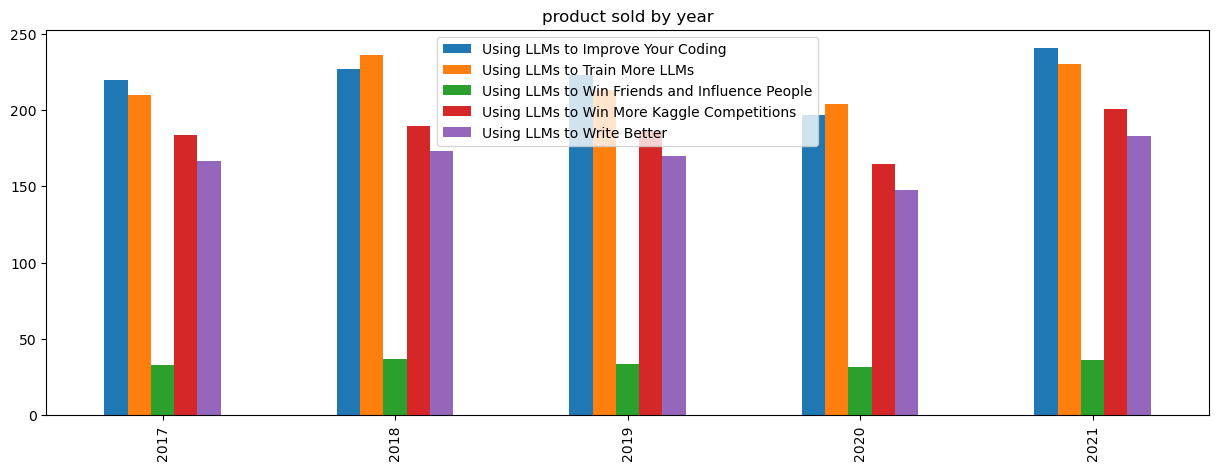

In [59]:
col = 'year'
res = pd.DataFrame(df[[col,'product','num_sold']].groupby([col,'product']).mean().values.reshape(len(years),len(products)), columns=products).set_index([years])
fig, ax = plt.subplots(figsize=(15, 5))
res.plot(kind='bar', ax=ax)
plt.title(f"product sold by {col}")

<Axes: >

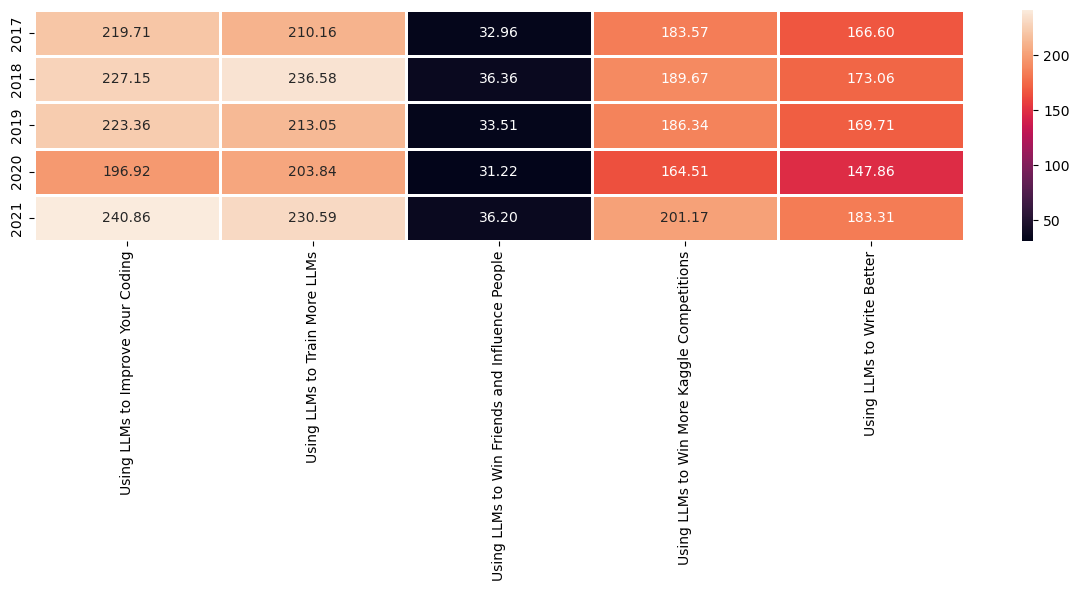

In [60]:
plt.figure(figsize=(15,3))
sns.heatmap(res, annot=True, fmt='.2f', linewidth=1)

# Get TRAIN TEST SPLIT

In [178]:
df = prepare_data(data, train_flag=True)
train_x, train_y, test_x, test_y = train_test_split(df)
print(train_x.shape)
print(test_x.shape)

(123255, 16)
(13695, 16)


In [175]:
test_x.head()

country  store  product  year  month  quarter  week  day  \
date                                                                   
2021-07-02        0      2        1  2021      7        3     4    2   
2021-07-02        2      2        1  2021      7        3     4    2   
2021-07-02        1      0        1  2021      7        3     4    2   
2021-07-02        3      0        2  2021      7        3     4    2   
2021-07-02        3      0        3  2021      7        3     4    2   

            DayOfWeek_sin  DayOfWeek_cos  month__mean  month__std  week__mean  \
date                                                                            
2021-07-02      -0.433884      -0.900969    40.734275    3.242083   47.967886   
2021-07-02      -0.433884      -0.900969   109.467761    8.946340  124.147110   
2021-07-02      -0.433884      -0.900969   755.145549   67.361238  858.232203   
2021-07-02      -0.433884      -0.900969    91.822536   10.061901   98.412069   
2021-07-02      -0.433884      -0.900969   466.530004   42.038330  558.282523   

             week__std  quarter__mean  quarter__std  
date                                                 
2021-07-02    9.635282      41.025479      2.709579  
2021-07-02   27.803735     108.135147      8.780766  
2021-07-02  173.520793     741.182312     67.353497  
2021-07-02    5.915466      96.121601      8.197821  
2021-07-02   56.932676     518.911853     52.044652

# Try models with engineered features only(month, week, year etc), without any lag variables

In [179]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Create the XGBRegressor model
xgb_model = XGBRegressor()

# Fit the model to the data
xgb_model.fit(train_x, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [180]:
y_pred_xg = xgb_model.predict(test_x)
mse_value = mean_squared_error(y_pred_xg, test_y)
res = pd.DataFrame(zip(map(int,y_pred_xg),test_y.values), columns=["predicted", "truth"])
res['date'] = test_y.index
print(f"MSE: {mse_value}")
res.head(10)

MSE: 560.0190329037187


predicted  truth       date
0         40     39 2021-07-02
1        110    118 2021-07-02
2        801    780 2021-07-02
3         99     98 2021-07-02
4        474    467 2021-07-02
5        118    120 2021-07-02
6         74     69 2021-07-02
7        125    119 2021-07-02
8         66     58 2021-07-02
9         85     81 2021-07-02

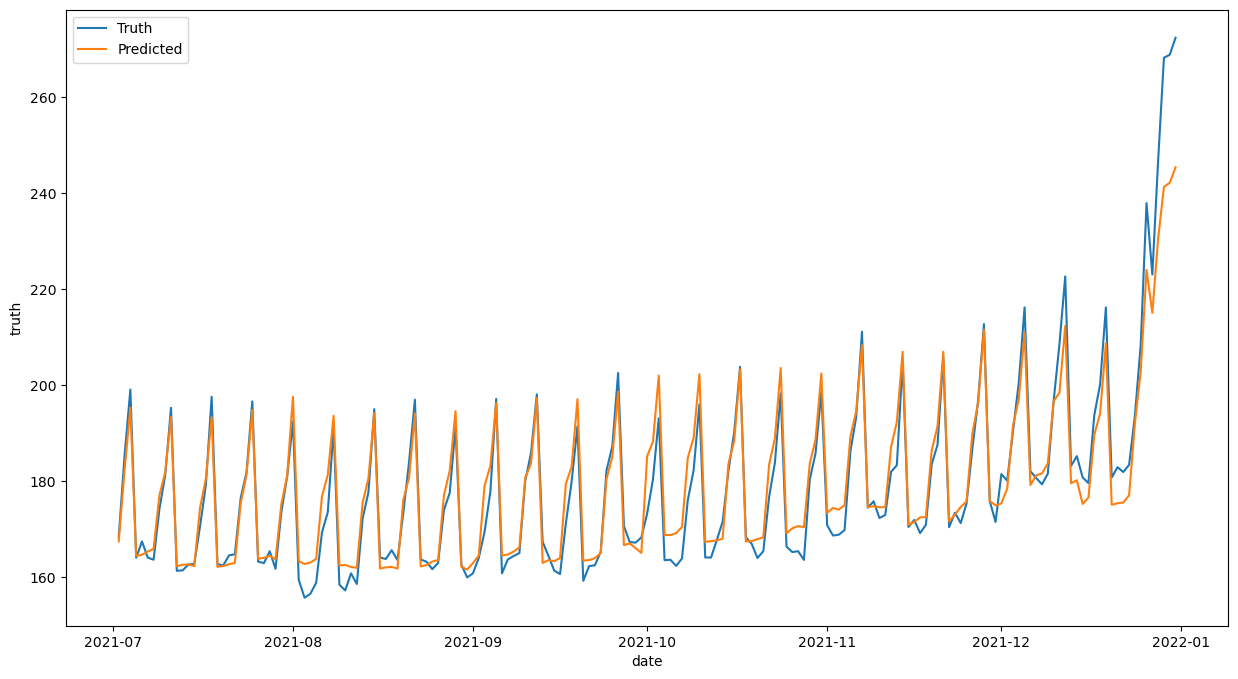

In [181]:
plt.figure(figsize=(15,8))
sns.lineplot(x='date', y='truth', data=res, ci=None, label='Truth')
sns.lineplot(x='date', y='predicted', data=res, ci=None, label='Predicted')
plt.legend()

In [182]:
from catboost import CatBoostRegressor
# Create the XGBRegressor model
cat_model = CatBoostRegressor(silent=True,depth=5)

# Fit the model to the data
cat_model.fit(train_x, train_y)

In [183]:
y_pred_cat = cat_model.predict(test_x)
mse_value = mean_squared_error(y_pred_cat, test_y)
res = pd.DataFrame(zip(map(int,y_pred_cat),test_y.values), columns=["predicted", "truth"])
res['date'] = test_y.index
print(f"MSE: {mse_value}")
res.head(10)

MSE: 395.7050459419002


predicted  truth       date
0         39     39 2021-07-02
1        108    118 2021-07-02
2        822    780 2021-07-02
3         98     98 2021-07-02
4        476    467 2021-07-02
5        118    120 2021-07-02
6         71     69 2021-07-02
7        124    119 2021-07-02
8         61     58 2021-07-02
9         82     81 2021-07-02

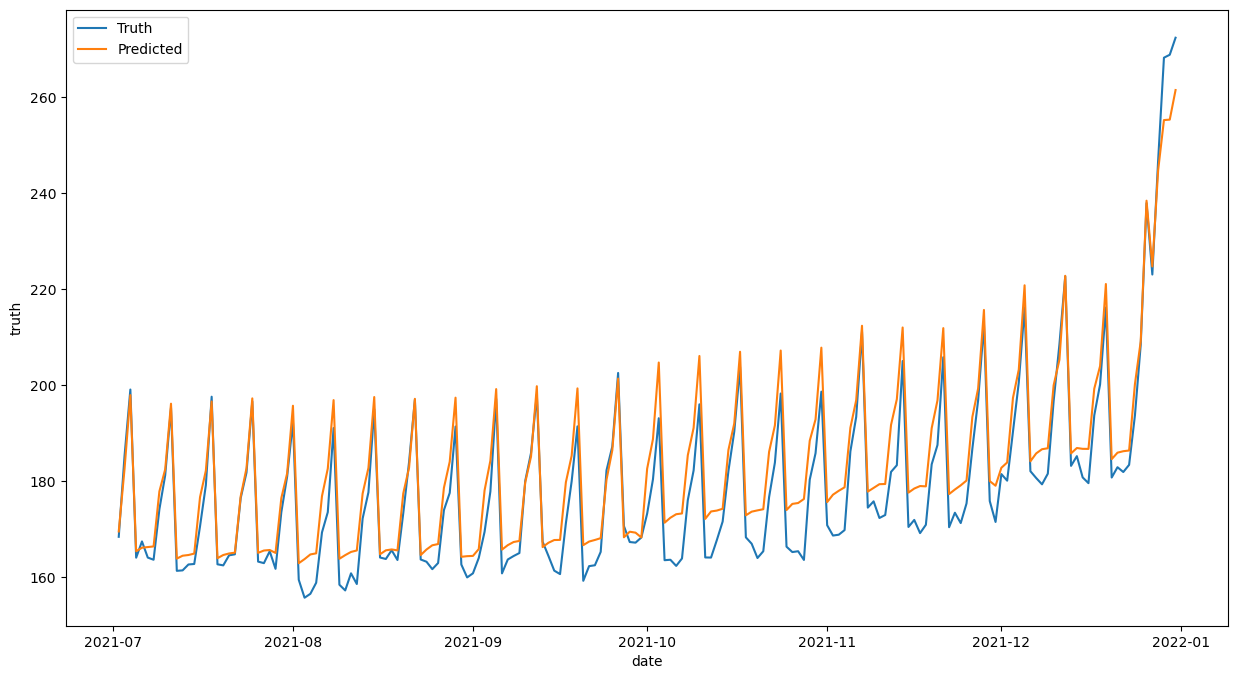

In [184]:
plt.figure(figsize=(15,8))
sns.lineplot(x='date', y='truth', data=res, ci=None, label='Truth')
sns.lineplot(x='date', y='predicted', data=res, ci=None, label='Predicted')
plt.legend()

In [185]:
xg_cat_pred = (y_pred_xg + y_pred_cat)/2
res = pd.DataFrame(zip(map(int,xg_cat_pred),test_y.values), columns=["predicted", "truth"])
res['date'] = test_y.index
print(mean_squared_error(xg_cat_pred, test_y))
res

406.3511510083286


predicted  truth       date
0             40     39 2021-07-02
1            109    118 2021-07-02
2            812    780 2021-07-02
3             99     98 2021-07-02
4            475    467 2021-07-02
...          ...    ...        ...
13690        213    252 2021-12-31
13691         15     22 2021-12-31
13692         58     63 2021-12-31
13693        181    183 2021-12-31
13694        260    260 2021-12-31

[13695 rows x 3 columns]

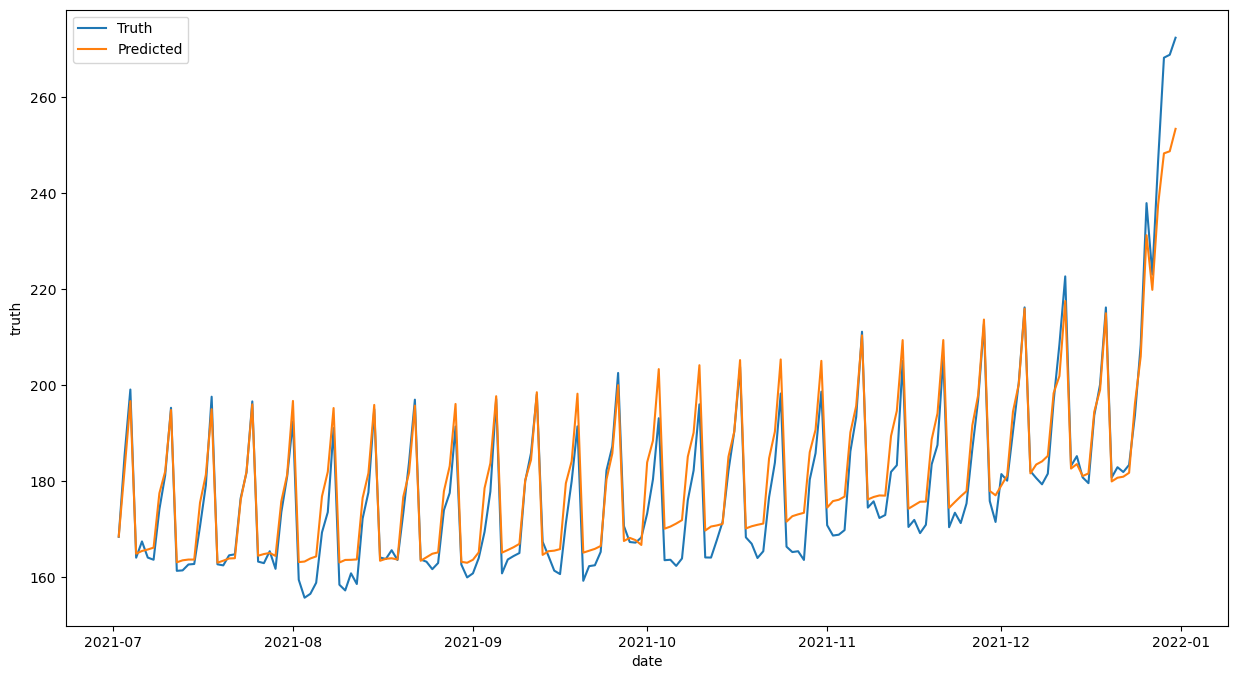

In [186]:
plt.figure(figsize=(15,8))
sns.lineplot(x='date', y='truth', data=res, ci=None, label='Truth')
sns.lineplot(x='date', y='predicted', data=res, ci=None, label='Predicted')
plt.legend()

In [81]:
#help(RandomForestRegressor)

In [82]:
from sklearn.ensemble import RandomForestRegressor
random_forest_model = RandomForestRegressor(n_estimators=100, max_depth=15)
random_forest_model.fit(train_x, train_y)

RandomForestRegressor(max_depth=15)

In [83]:
y_pred = random_forest_model.predict(test_x)
mse_value = mean_squared_error(y_pred, test_y)
res = pd.DataFrame(zip(map(int,y_pred),test_y.values), columns=["predicted", "truth"])
res['date'] = test_y.index
print(f"MSE: {mse_value}")
res.head(10)

MSE: 1095.6292903594067


predicted  truth       date
0         43     39 2021-07-02
1        110    118 2021-07-02
2        800    780 2021-07-02
3         91     98 2021-07-02
4        492    467 2021-07-02
5        123    120 2021-07-02
6         71     69 2021-07-02
7        130    119 2021-07-02
8         63     58 2021-07-02
9         86     81 2021-07-02

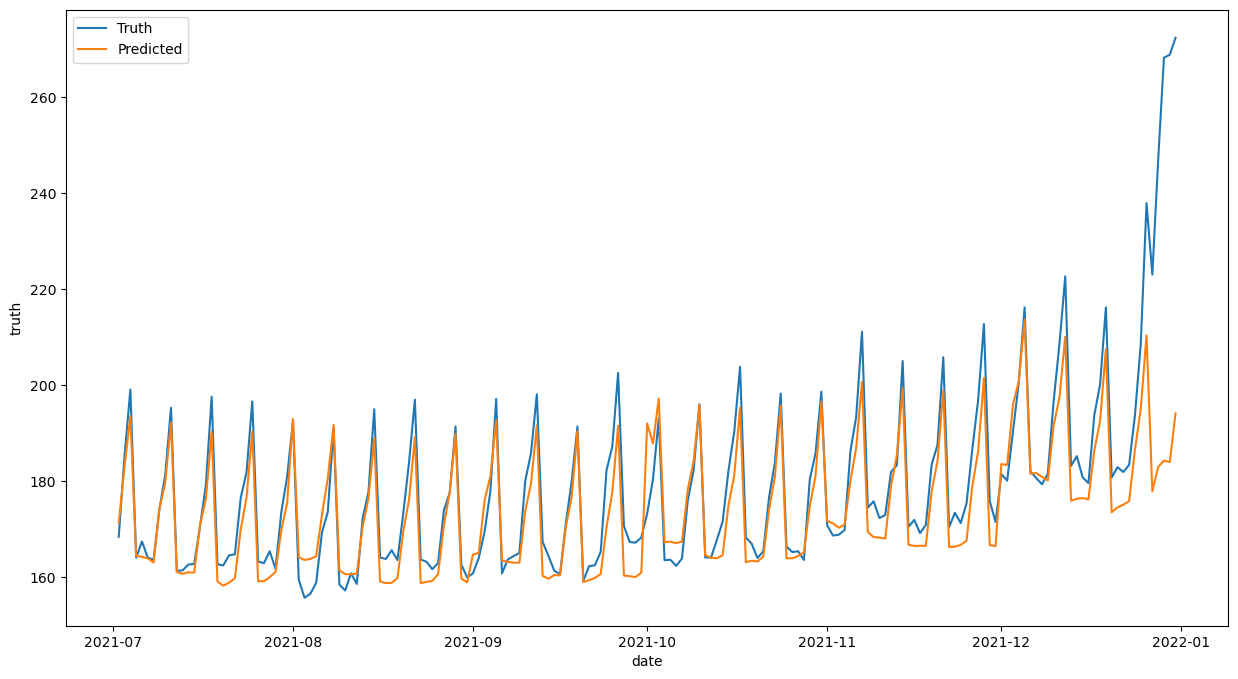

In [84]:
plt.figure(figsize=(15,8))
sns.lineplot(x='date', y='truth', data=res, ci=None, label='Truth')
sns.lineplot(x='date', y='predicted', data=res, ci=None, label='Predicted')
plt.legend()

In [187]:
from sklearn.linear_model import LinearRegression, Ridge
linear_model = LinearRegression()
linear_model.fit(train_x, train_y)
y_pred = linear_model.predict(test_x)
mse_value = mean_squared_error(y_pred, test_y)
res = pd.DataFrame(zip(map(int,y_pred),test_y.values), columns=["predicted", "truth"])
res['date'] = test_y.index
print(f"MSE: {mse_value}")
res.head(10)

MSE: 1565.5852549384686


predicted  truth       date
0         32     39 2021-07-02
1         94    118 2021-07-02
2        673    780 2021-07-02
3         96     98 2021-07-02
4        455    467 2021-07-02
5        108    120 2021-07-02
6         60     69 2021-07-02
7        117    119 2021-07-02
8         62     58 2021-07-02
9         84     81 2021-07-02

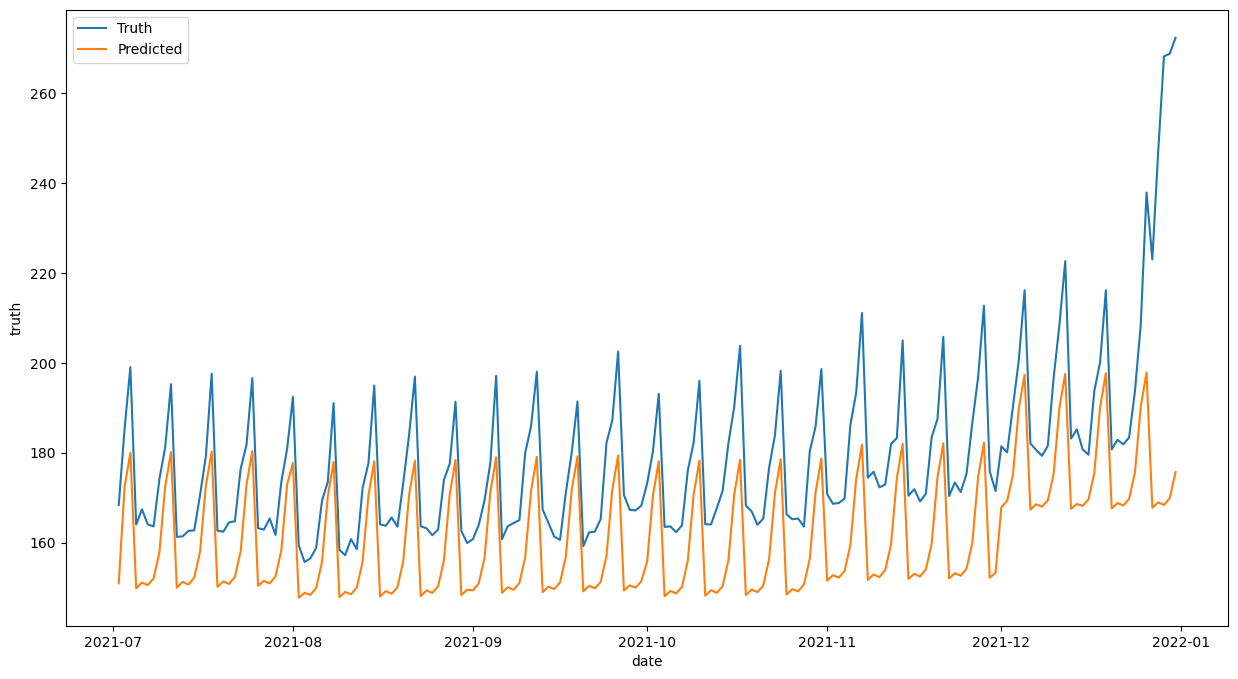

In [188]:
plt.figure(figsize=(15,8))
sns.lineplot(x='date', y='truth', data=res, ci=None, label='Truth')
sns.lineplot(x='date', y='predicted', data=res, ci=None, label='Predicted')
plt.legend()

# Lets train on whole date and predict test with XGBoost and Catboost

In [189]:
data = pd.read_csv("/kaggle/input/playground-series-s3e19/train.csv")
df = prepare_data(data, train_flag=True)
train_x = df.drop(['num_sold'], axis=1)
train_y = df['num_sold']

test = pd.read_csv("/kaggle/input/playground-series-s3e19/test.csv")
test_x = prepare_data(test).drop(['id'], axis=1)


In [190]:
train_x.tail(2)

country  store  product  year  month  quarter  week  day  \
date                                                                   
2021-12-31        4      2        0  2021     12        4     4   31   
2021-12-31        1      2        4  2021     12        4     4   31   

            DayOfWeek_sin  DayOfWeek_cos  month__mean  month__std  week__mean  \
date                                                                            
2021-12-31      -0.433884      -0.900969   158.457663   27.452269  145.151936   
2021-12-31      -0.433884      -0.900969   203.423492   48.279311  160.864780   

            week__std  quarter__mean  quarter__std  
date                                                
2021-12-31  16.819015     158.366297     27.203346  
2021-12-31  37.537938     202.679996     48.619283

In [191]:
test_x.head(2)

country  store  product  year  month  quarter  week  day  \
date                                                                   
2022-01-01        0      1        0  2022      1        1     5    1   
2022-01-01        4      1        4  2022      1        1     5    1   

            DayOfWeek_sin  DayOfWeek_cos  month__mean  month__std  week__mean  \
date                                                                            
2022-01-01      -0.974928      -0.222521    26.060079    2.581745   32.968352   
2022-01-01      -0.974928      -0.222521    67.652357    5.473649   58.789391   

            week__std  quarter__mean  quarter__std  
date                                                
2022-01-01   2.317735      24.616998      2.946298  
2022-01-01   9.180176      75.632350      6.241216

In [192]:
xgb_model = XGBRegressor()
xgb_model.fit(train_x, train_y)
y_pred_xg = xgb_model.predict(test_x)

In [197]:
xg_boost_submission = pd.DataFrame({'id': test['id'], 'num_sold': y_pred_xg})
xg_boost_submission.to_csv('submission.csv', index=False)

In [194]:
cat_model = CatBoostRegressor(silent=True,depth=5)
cat_model.fit(train_x, train_y)
y_pred_cat = cat_model.predict(test_x)

In [196]:
cat_boost_submission = pd.DataFrame({'id': test['id'], 'num_sold': y_pred_cat})
cat_boost_submission.to_csv('submission.csv', index=False)

# MODELS WITH ONE WEEK LAG

In [130]:
no_lags = 7
#df11 = data[(data['country']=='Argentina') & (data['store']=='Kagglazon') & (data['product'] == 'Using LLMs to Improve Your Coding')]
df = clreate_lags_by_group(data, lags=no_lags)
df = prepare_data(df, train_flag=True)
train_x, train_y, test_x, test_y = train_test_split(df)

In [131]:
train_x.head()

country  store  product  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  \
date                                                                            
2017-04-01        1      0        1  576.0  598.0  573.0  610.0  601.0  757.0   
2017-04-01        1      1        0  109.0  103.0   86.0   99.0  105.0  116.0   
2017-04-01        3      0        3  502.0  468.0  489.0  535.0  552.0  591.0   
2017-04-01        1      0        4  590.0  610.0  558.0  526.0  624.0  681.0   
2017-04-01        0      1        1   36.0   40.0   35.0   39.0   35.0   41.0   

            lag_7  ...  Rolling_Std_30  Rolling_Mean_90  Rolling_Std_90  year  \
date               ...                                                          
2017-04-01  661.0  ...       31.914239       588.026160       31.914239  2017   
2017-04-01  111.0  ...        9.320404       103.917908        9.320404  2017   
2017-04-01  571.0  ...       30.644857       497.545770       30.644857  2017   
2017-04-01  665.0  ...       32.304640       590.131729       32.304640  2017   
2017-04-01   41.0  ...        2.470172        37.133277        2.470172  2017   

            month  quarter  week  day  DayOfWeek_sin  DayOfWeek_cos  
date                                                                 
2017-04-01      4        2     5    1      -0.974928      -0.222521  
2017-04-01      4        2     5    1      -0.974928      -0.222521  
2017-04-01      4        2     5    1      -0.974928      -0.222521  
2017-04-01      4        2     5    1      -0.974928      -0.222521  
2017-04-01      4        2     5    1      -0.974928      -0.222521  

[5 rows x 23 columns]

In [133]:
test_x.head()

country  store  product  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  \
date                                                                            
2021-07-11        0      0        4  130.0  132.0  120.0  117.0  110.0  107.0   
2021-07-11        0      1        0   31.0   29.0   27.0   26.0   27.0   27.0   
2021-07-11        1      0        3  637.0  574.0  563.0  566.0  615.0  592.0   
2021-07-11        0      1        2    4.0    4.0    3.0    4.0    3.0    3.0   
2021-07-11        0      1        4   21.0   21.0   20.0   20.0   20.0   19.0   

            lag_7  ...  Rolling_Std_30  Rolling_Mean_90  Rolling_Std_90  year  \
date               ...                                                          
2021-07-11  146.0  ...        7.870029       127.547757        7.870029  2021   
2021-07-11   32.0  ...        2.154578        29.487836        2.154578  2021   
2021-07-11  729.0  ...       42.545966       606.869554       42.545966  2021   
2021-07-11    5.0  ...        0.480429         3.834564        0.480429  2021   
2021-07-11   23.0  ...        0.636018        20.768953        0.636018  2021   

            month  quarter  week  day  DayOfWeek_sin  DayOfWeek_cos  
date                                                                 
2021-07-11      7        3     6   11      -0.781831        0.62349  
2021-07-11      7        3     6   11      -0.781831        0.62349  
2021-07-11      7        3     6   11      -0.781831        0.62349  
2021-07-11      7        3     6   11      -0.781831        0.62349  
2021-07-11      7        3     6   11      -0.781831        0.62349  

[5 rows x 23 columns]

# XGBoost

In [134]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
# Create the XGBRegressor model
xgb_model_lagged = XGBRegressor()

# Fit the model to the data
xgb_model_lagged.fit(train_x.values, train_y.values)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [135]:
y_pred_xg = xgb_model_lagged.predict(test_x)
mse_value = mean_squared_error(y_pred_xg, test_y)
res = pd.DataFrame(zip(map(int,y_pred_xg),test_y.values), columns=["predicted", "truth"])
res['date'] = test_y.index
print(f"MSE: {mse_value}")
res.head(10)

MSE: 405.93903324435615


predicted  truth       date
0        142    137 2021-07-11
1         33     35 2021-07-11
2        665    652 2021-07-11
3          4      5 2021-07-11
4         22     23 2021-07-11
5        174    166 2021-07-11
6        139    156 2021-07-11
7        188    185 2021-07-11
8        125    110 2021-07-11
9         95     93 2021-07-11

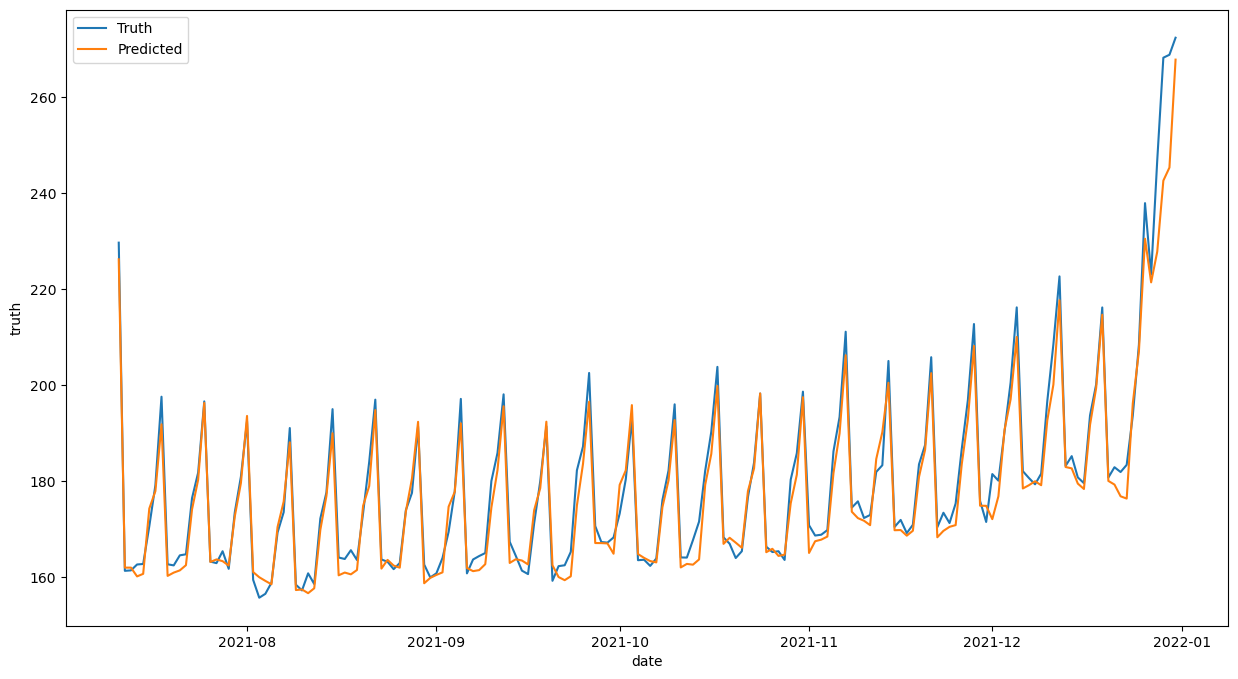

In [136]:
plt.figure(figsize=(15,8))
sns.lineplot(x='date', y='truth', data=res, ci=None, label='Truth')
sns.lineplot(x='date', y='predicted', data=res, ci=None, label='Predicted')
plt.legend()

# Parameter tunning XGBoost

In [ ]:
from sklearn.model_selection import GridSearchCV
xgb_model = XGBRegressor()

# Define hyperparameters to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 9],
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='r2', cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(train_x, train_y)

# Get the best hyperparameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [148]:
# Create the XGBRegressor model
xgb_model_lagged = XGBRegressor( max_depth= 5, n_estimators= 200)

# Fit the model to the data
xgb_model_lagged.fit(train_x.values, train_y.values)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [149]:
y_pred_xg = xgb_model_lagged.predict(test_x)
mse_value = mean_squared_error(y_pred_xg, test_y)
res = pd.DataFrame(zip(map(int,y_pred_xg),test_y.values), columns=["predicted", "truth"])
res['date'] = test_y.index
print(f"MSE: {mse_value}")
res.head(10)

MSE: 354.565640511471


predicted  truth       date
0        138    137 2021-07-11
1         32     35 2021-07-11
2        704    652 2021-07-11
3          4      5 2021-07-11
4         22     23 2021-07-11
5        173    166 2021-07-11
6        136    156 2021-07-11
7        194    185 2021-07-11
8        123    110 2021-07-11
9         93     93 2021-07-11

# Catboost

In [140]:
from catboost import CatBoostRegressor
# Create the XGBRegressor model
cat_model_lagged = CatBoostRegressor(silent=True)

# Fit the model to the data
cat_model_lagged.fit(train_x, train_y)

In [141]:
y_pred_cat = cat_model_lagged.predict(test_x)
mse_value = mean_squared_error(y_pred_cat, test_y)
res = pd.DataFrame(zip(map(int,y_pred_cat),test_y.values), columns=["predicted", "truth"])
res['date'] = test_y.index
print(f"MSE: {mse_value}")
res.head(10)

MSE: 350.8627316526397


predicted  truth       date
0        139    137 2021-07-11
1         34     35 2021-07-11
2        684    652 2021-07-11
3          3      5 2021-07-11
4         22     23 2021-07-11
5        178    166 2021-07-11
6        136    156 2021-07-11
7        188    185 2021-07-11
8        120    110 2021-07-11
9         95     93 2021-07-11

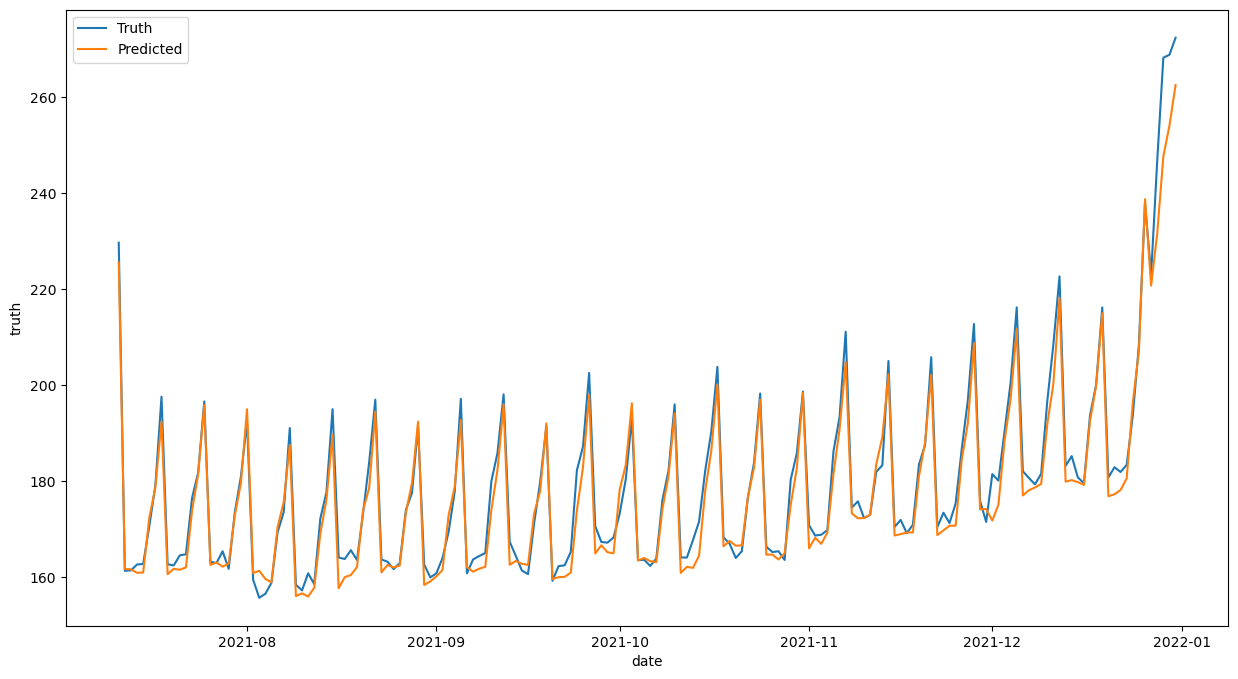

In [142]:
plt.figure(figsize=(15,8))
sns.lineplot(x='date', y='truth', data=res, ci=None, label='Truth')
sns.lineplot(x='date', y='predicted', data=res, ci=None, label='Predicted')
plt.legend()

# XGBoost + Catboost

In [151]:
mean_squared_error((y_pred_xg + y_pred_cat)/2, test_y)

337.5223411010031

# Parameter tunning catboost

In [ ]:
from sklearn.model_selection import GridSearchCV
# Define the hyperparameters to tune
params = {
    'iterations': [1000, 2000, 3000,4000],
    'depth': [5, 7,9,11],
}

# Create a grid search object
cat_model_lagged = CatBoostRegressor(silent=True)

grid_search = GridSearchCV(estimator=cat_model_lagged, param_grid=params, cv=5)
grid_search.fit(train_x.values, train_y.values)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

In [152]:
cat_model_lagged = CatBoostRegressor(silent=True, depth= 7, iterations= 4000, learning_rate=.01)

# Fit the model to the data
cat_model_lagged.fit(train_x, train_y)

In [155]:
y_pred_cat = cat_model_lagged.predict(test_x)
mse_value = mean_squared_error(y_pred, test_y)
res = pd.DataFrame(zip(map(int,y_pred),test_y.values), columns=["predicted", "truth"])
print(f"MSE: {mse_value}")
res.head(10)

MSE: 341.23772909725307


predicted  truth
0        139    137
1         33     35
2        686    652
3          3      5
4         22     23
5        174    166
6        136    156
7        188    185
8        122    110
9         94     93

In [156]:
mean_squared_error((y_pred_xg + y_pred_cat)/2, test_y)

334.59820222353886

In [157]:
linear_model = Ridge(alpha=0.1, fit_intercept=True, solver='auto')
linear_model.fit(train_x, train_y)

y_pred = linear_model.predict(test_x)
mse_value = mean_squared_error(y_pred, test_y)
res = pd.DataFrame(zip(map(int,y_pred),test_y.values), columns=["predicted", "truth"])
res['date'] = test_y.index
print(f"MSE: {mse_value}")
res.head(10)

MSE: 461.84724417902163


predicted  truth       date
0        145    137 2021-07-11
1         40     35 2021-07-11
2        666    652 2021-07-11
3         13      5 2021-07-11
4         31     23 2021-07-11
5        170    166 2021-07-11
6        137    156 2021-07-11
7        193    185 2021-07-11
8        127    110 2021-07-11
9         96     93 2021-07-11

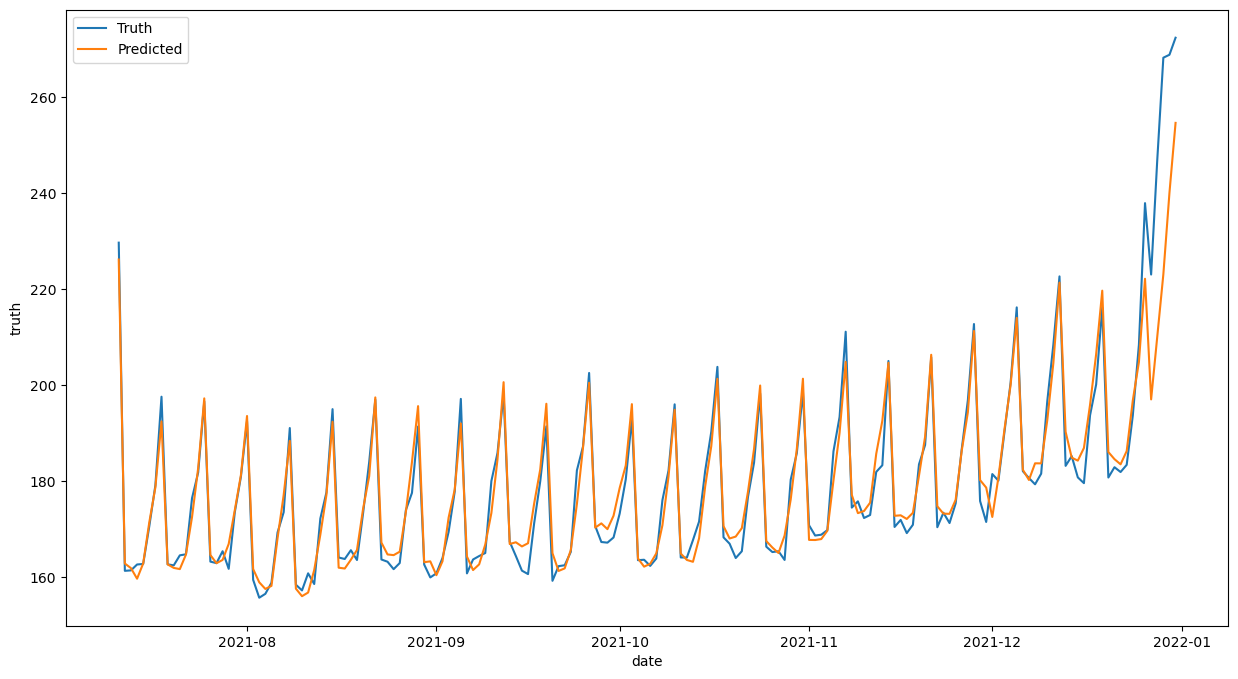

In [158]:
plt.figure(figsize=(15,8))
sns.lineplot(x='date', y='truth', data=res, ci=None, label='Truth')
sns.lineplot(x='date', y='predicted', data=res, ci=None, label='Predicted')
plt.legend()

# SO FAR WE CREATED LAG FIRST AND THEN DEVIDED THE DATA IN TRAIN and TEST, BUT WITH test FILE WE DO NOT HAVE THIS LAG INFORMATION AVAILABLE IN ADVANCE

# SO NOW WE FIRST MAKE PREDICTION AND THEN USE IT TO MAKE ANOTHER PREDICTION BY MAKE IT A LAG VARIABLE

In [11]:
def create_lags_for_prediction(row, predictions, no_lags): 
    for i in range(no_lags):
        row['lag_{}'.format(i+1)] = predictions[-(i+1)] 
    row['differencing'] = predictions[-1]-predictions[-2]
    for lag in [14,30,90]:
        time = pd.Series(predictions[-lag:])
        row['Rolling_Mean_{}'.format(lag)] = time.ewm(alpha=alpha).mean().iloc[-1]
        row['Rolling_Std_{}'.format(lag)] = time.ewm(alpha=alpha).std().iloc[-1]
    return row

In [12]:
def predict_group(model, data,initial_list, no_lags, result, cols):
    predictions = initial_list.copy()
    for i in range(len(data)):
        row = data.iloc[i]
        row = create_lags_for_prediction(row,predictions,no_lags)
        row = row[cols]
        y_pred = model.predict([row])[0]
        predictions.append(y_pred)
    res = pd.DataFrame(zip(result,predictions[len(initial_list):]), columns=['id', 'predicted_num_sold'])
    res.index = result.index
    return res

In [13]:
def predict(model,data,train_data,cols,no_lags):
    data = prepare_data(data)
    #train_data = prepare_data(train_data)
    countries = list(set(data['country']))
    stores = list(set(data['store']))
    products = list(set(data['product']))
    final_data = pd.DataFrame()
    for country in countries:
        for product in products:
            for store in stores:
                temp = data[(data['country'] == country) & (data['store'] == store) & (data['product'] == product)]
                initial_list = list(train_data[(train_data['country'] == country) & (train_data['store'] == store) & (train_data['product'] == product)]['num_sold'])
                temp = predict_group(model, temp.drop(['id'], axis=1), initial_list, no_lags, temp['id'], cols)          
                final_data = pd.concat([final_data,temp], axis=0)
                print(final_data.shape, end="")             
    return final_data

In [16]:
no_lags = 7
train_x, train_y, test_x, test_y = train_test_split(data)
train = clreate_lags_by_group(pd.concat([train_x,train_y], axis=1), lags=no_lags)
train = prepare_data(train, train_flag=True)
train_x = train.drop(['num_sold'], axis=1)
train_y = train['num_sold']

In [17]:
train_x.head()

country  store  product  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  \
date                                                                            
2017-04-01        3      2        2   22.0   22.0   24.0   23.0   23.0   29.0   
2017-04-01        4      2        1  105.0  103.0   97.0  102.0  113.0  138.0   
2017-04-01        0      1        0   36.0   32.0   31.0   34.0   31.0   36.0   
2017-04-01        1      1        2   17.0   16.0   18.0   16.0   17.0   20.0   
2017-04-01        2      0        2   47.0   43.0   47.0   43.0   44.0   52.0   

            lag_7  ...  Rolling_Std_30  Rolling_Mean_90  Rolling_Std_90  year  \
date               ...                                                          
2017-04-01   29.0  ...        2.404323        23.822610        2.387231  2017   
2017-04-01  114.0  ...       11.094895       107.860038       11.142566  2017   
2017-04-01   35.0  ...        2.949672        33.011868        2.961228  2017   
2017-04-01   19.0  ...        1.445267        17.245095        1.460543  2017   
2017-04-01   45.0  ...        3.031350        45.648702        3.095779  2017   

            month  quarter  week  day  DayOfWeek_sin  DayOfWeek_cos  
date                                                                 
2017-04-01      4        2     5    1      -0.974928      -0.222521  
2017-04-01      4        2     5    1      -0.974928      -0.222521  
2017-04-01      4        2     5    1      -0.974928      -0.222521  
2017-04-01      4        2     5    1      -0.974928      -0.222521  
2017-04-01      4        2     5    1      -0.974928      -0.222521  

[5 rows x 24 columns]

In [18]:
test_x.head()

id       date  country         store  \
123255  123255 2021-07-02  Estonia  Kaggle Learn   
123256  123256 2021-07-02  Estonia  Kaggle Learn   
123257  123257 2021-07-02  Estonia  Kaggle Learn   
123258  123258 2021-07-02  Estonia  Kaggle Learn   
123259  123259 2021-07-02  Estonia  Kaggle Learn   

                                               product  
123255               Using LLMs to Improve Your Coding  
123256                   Using LLMs to Train More LLMs  
123257  Using LLMs to Win Friends and Influence People  
123258      Using LLMs to Win More Kaggle Competitions  
123259                      Using LLMs to Write Better

In [19]:
# Create the XGBRegressor model
xgb_model_lagged = XGBRegressor()

# Fit the model to the data
xgb_model_lagged.fit(train_x.values, train_y.values)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [20]:
pred = predict(xgb_model_lagged, test_x, pd.concat([train_x,train_y],axis=1),train_x.columns, no_lags)

(182, 2)(364, 2)(546, 2)(728, 2)(910, 2)(1092, 2)(1274, 2)(1456, 2)(1638, 2)(1820, 2)(2002, 2)(2184, 2)(2366, 2)(2548, 2)(2730, 2)(2912, 2)(3094, 2)(3276, 2)(3458, 2)(3640, 2)(3822, 2)(4004, 2)(4186, 2)(4368, 2)(4550, 2)(4732, 2)(4914, 2)(5096, 2)(5278, 2)(5460, 2)(5643, 2)(5826, 2)(6009, 2)(6192, 2)(6375, 2)(6558, 2)(6741, 2)(6924, 2)(7107, 2)(7290, 2)(7473, 2)(7656, 2)(7839, 2)(8022, 2)(8205, 2)(8388, 2)(8571, 2)(8754, 2)(8937, 2)(9120, 2)(9303, 2)(9486, 2)(9669, 2)(9852, 2)(10035, 2)(10218, 2)(10401, 2)(10584, 2)(10767, 2)(10950, 2)(11133, 2)(11316, 2)(11499, 2)(11682, 2)(11865, 2)(12048, 2)(12231, 2)(12414, 2)(12597, 2)(12780, 2)(12963, 2)(13146, 2)(13329, 2)(13512, 2)(13695, 2)

In [21]:
df_merged_xg = test_x.merge(pred, on='id', how='inner')
df_merged_xg['true_num_sold'] = test_y.values

mse_value = mean_squared_error(df_merged_xg['true_num_sold'], df_merged_xg['predicted_num_sold'])
print("MSE:", mse_value)
df_merged_xg[['date','true_num_sold','predicted_num_sold']].head(5)

MSE: 1281.8367021677514


date  true_num_sold  predicted_num_sold
0 2021-07-02             80           81.956093
1 2021-07-02             69           74.683479
2 2021-07-02             12           11.419673
3 2021-07-02             57           58.495556
4 2021-07-02             60           63.899029

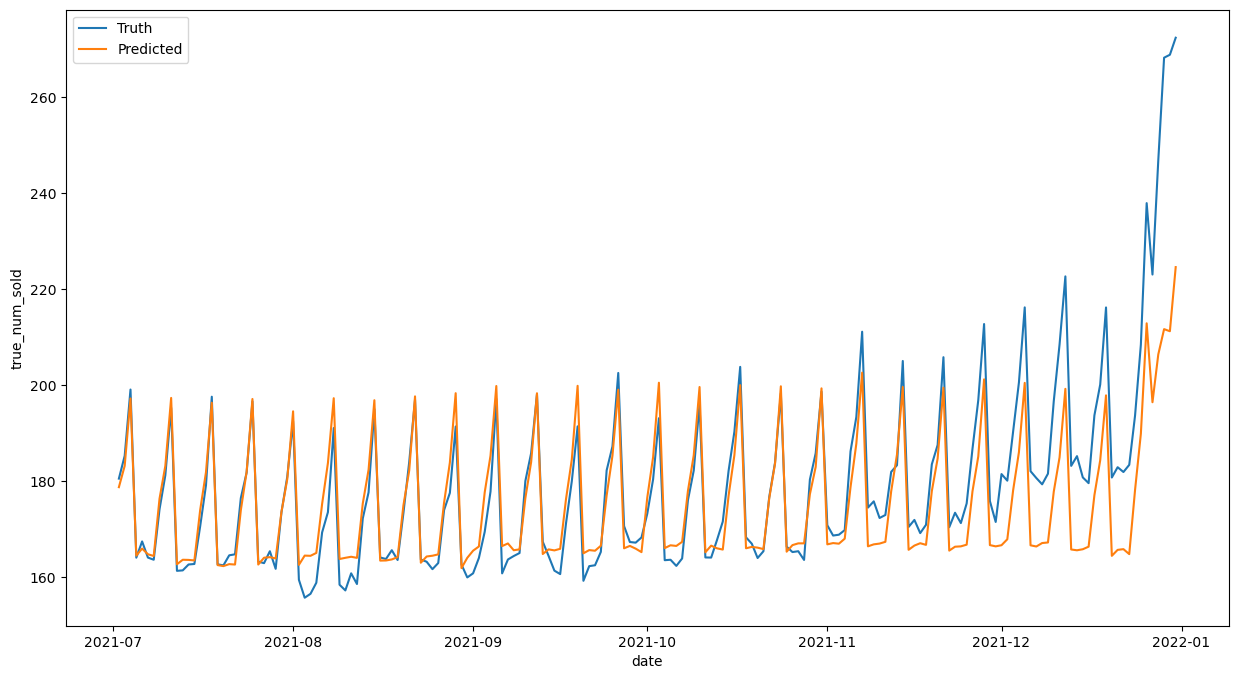

In [22]:
plt.figure(figsize=(15,8))
sns.lineplot(x='date', y='true_num_sold', data=df_merged_xg, ci=None, label='Truth')
sns.lineplot(x='date', y='predicted_num_sold', data=df_merged_xg, ci=None, label='Predicted')
plt.legend()

In [14]:
def calculate_smape(true_values, predicted_values):
    smape = np.mean(2 * abs(true_values - predicted_values) / (abs(true_values) + abs(predicted_values))) * 100
    return(smape)

In [329]:
calculate_smape(df_merged_xg['true_num_sold'],df_merged_xg['predicted_num_sold'])

10.89128574065615

In [23]:
from catboost import CatBoostRegressor
# Create the XGBRegressor model
cat_model_lagged = CatBoostRegressor(silent=True, depth= 7, iterations= 3000, learning_rate=.009)

# Fit the model to the data
cat_model_lagged.fit(train_x.values, train_y.values)

pred = predict(cat_model_lagged, test_x, pd.concat([train_x,train_y],axis=1),train_x.columns, no_lags)

(182, 2)(364, 2)(546, 2)(728, 2)(910, 2)(1092, 2)(1274, 2)(1456, 2)(1638, 2)(1820, 2)(2002, 2)(2184, 2)(2366, 2)(2548, 2)(2730, 2)(2912, 2)(3094, 2)(3276, 2)(3458, 2)(3640, 2)(3822, 2)(4004, 2)(4186, 2)(4368, 2)(4550, 2)(4732, 2)(4914, 2)(5096, 2)(5278, 2)(5460, 2)(5643, 2)(5826, 2)(6009, 2)(6192, 2)(6375, 2)(6558, 2)(6741, 2)(6924, 2)(7107, 2)(7290, 2)(7473, 2)(7656, 2)(7839, 2)(8022, 2)(8205, 2)(8388, 2)(8571, 2)(8754, 2)(8937, 2)(9120, 2)(9303, 2)(9486, 2)(9669, 2)(9852, 2)(10035, 2)(10218, 2)(10401, 2)(10584, 2)(10767, 2)(10950, 2)(11133, 2)(11316, 2)(11499, 2)(11682, 2)(11865, 2)(12048, 2)(12231, 2)(12414, 2)(12597, 2)(12780, 2)(12963, 2)(13146, 2)(13329, 2)(13512, 2)(13695, 2)

In [24]:
df_merged_cat = test_x.merge(pred, on='id', how='inner')
df_merged_cat['true_num_sold'] = test_y.values

mse_value = mean_squared_error(df_merged_cat['true_num_sold'], df_merged_cat['predicted_num_sold'])
print("MSE:", mse_value)
df_merged_cat[['date','true_num_sold','predicted_num_sold']].head(5)

MSE: 1145.0537413579054


date  true_num_sold  predicted_num_sold
0 2021-07-02             80           84.889518
1 2021-07-02             69           78.220625
2 2021-07-02             12           12.161308
3 2021-07-02             57           59.218334
4 2021-07-02             60           66.270859

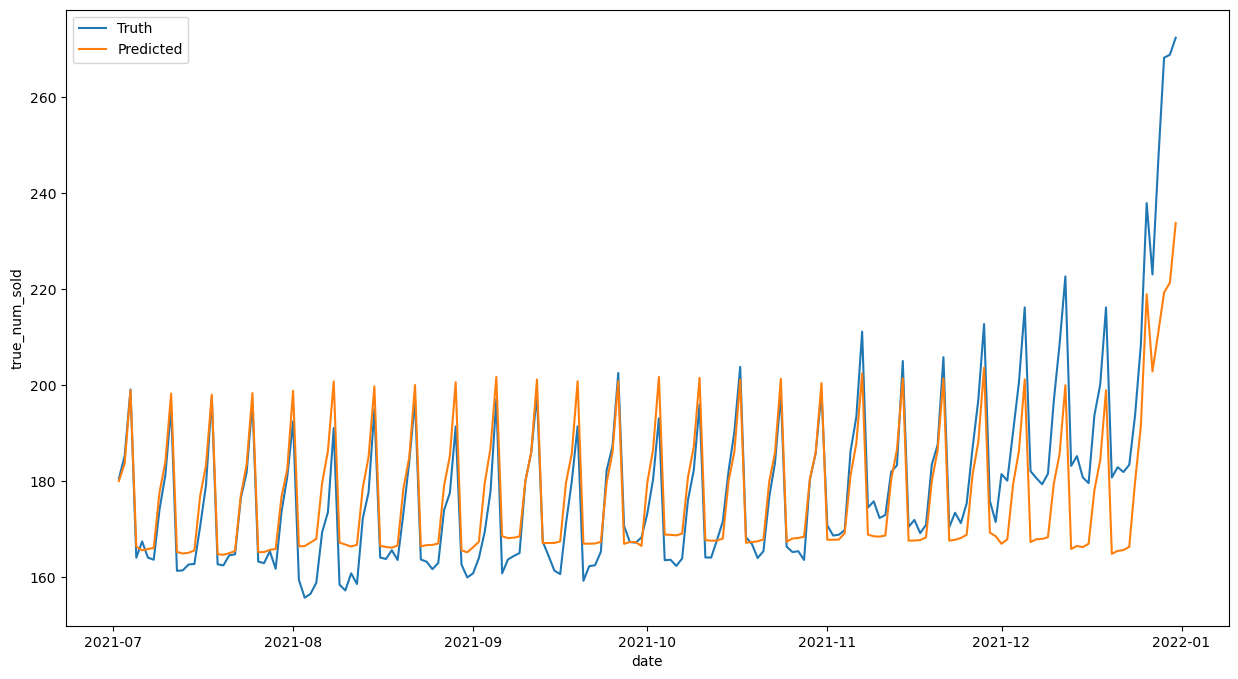

In [25]:
plt.figure(figsize=(15,8))
sns.lineplot(x='date', y='true_num_sold', data=df_merged_cat, ci=None, label='Truth')
sns.lineplot(x='date', y='predicted_num_sold', data=df_merged_cat, ci=None, label='Predicted')
plt.legend()

In [26]:
calculate_smape(df_merged_cat['true_num_sold'],df_merged_cat['predicted_num_sold'])

13.575130308194709

In [27]:
linear_model = Ridge(alpha=0.1, fit_intercept=True, solver='auto')
linear_model.fit(train_x.values, train_y.values)
pred = predict(linear_model, test_x, pd.concat([train_x,train_y],axis=1),train_x.columns, no_lags)

(182, 2)(364, 2)(546, 2)(728, 2)(910, 2)(1092, 2)(1274, 2)(1456, 2)(1638, 2)(1820, 2)(2002, 2)(2184, 2)(2366, 2)(2548, 2)(2730, 2)(2912, 2)(3094, 2)(3276, 2)(3458, 2)(3640, 2)(3822, 2)(4004, 2)(4186, 2)(4368, 2)(4550, 2)(4732, 2)(4914, 2)(5096, 2)(5278, 2)(5460, 2)(5643, 2)(5826, 2)(6009, 2)(6192, 2)(6375, 2)(6558, 2)(6741, 2)(6924, 2)(7107, 2)(7290, 2)(7473, 2)(7656, 2)(7839, 2)(8022, 2)(8205, 2)(8388, 2)(8571, 2)(8754, 2)(8937, 2)(9120, 2)(9303, 2)(9486, 2)(9669, 2)(9852, 2)(10035, 2)(10218, 2)(10401, 2)(10584, 2)(10767, 2)(10950, 2)(11133, 2)(11316, 2)(11499, 2)(11682, 2)(11865, 2)(12048, 2)(12231, 2)(12414, 2)(12597, 2)(12780, 2)(12963, 2)(13146, 2)(13329, 2)(13512, 2)(13695, 2)

In [28]:
df_merged_ridge = test_x.merge(pred, on='id', how='inner')
df_merged_ridge['true_num_sold'] = test_y.values

mse_value = mean_squared_error(df_merged_ridge['true_num_sold'], df_merged_ridge['predicted_num_sold'])
print("MSE:", mse_value)
df_merged_ridge[['date','true_num_sold','predicted_num_sold']].head(5)

MSE: 4227.130552414544


date  true_num_sold  predicted_num_sold
0 2021-07-02             80           82.769210
1 2021-07-02             69           75.962083
2 2021-07-02             12           12.824042
3 2021-07-02             57           56.114765
4 2021-07-02             60           63.646716

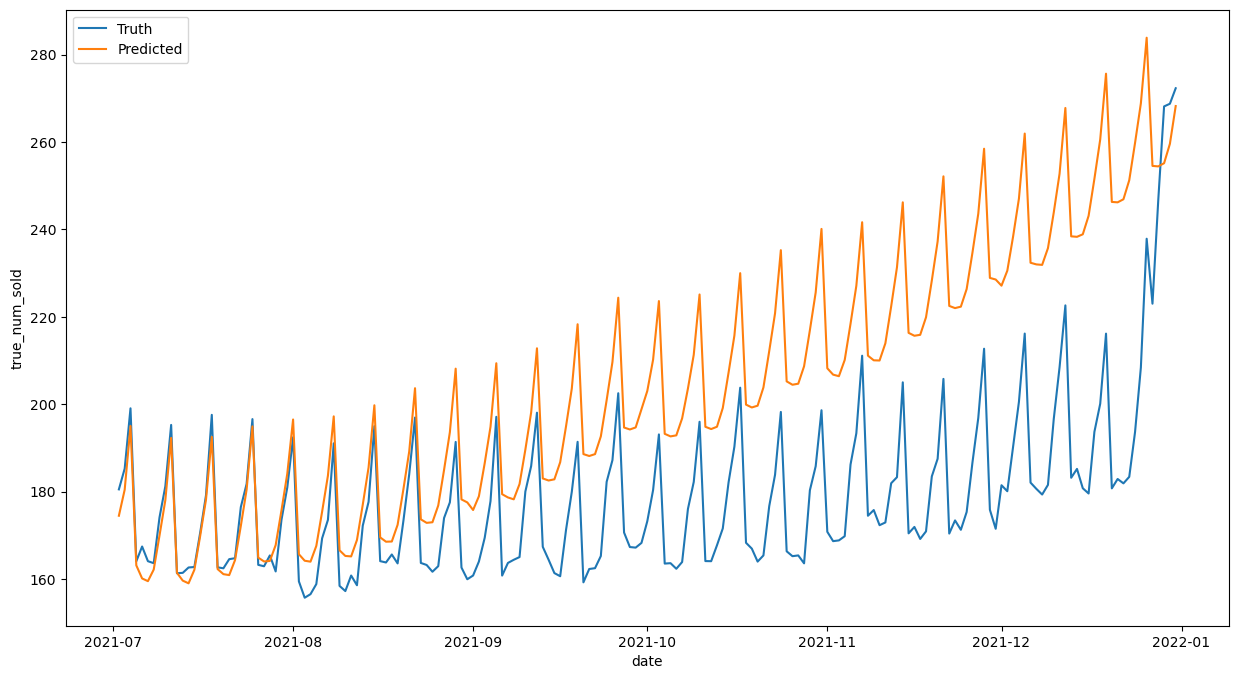

In [29]:
plt.figure(figsize=(15,8))
sns.lineplot(x='date', y='true_num_sold', data=df_merged_ridge, ci=None, label='Truth')
sns.lineplot(x='date', y='predicted_num_sold', data=df_merged_ridge, ci=None, label='Predicted')
plt.legend()

# XGBoost + Catboost

In [30]:
ens = pd.DataFrame()
ens['true_num_sold'] = df_merged_xg['true_num_sold']
ens['date'] = df_merged_xg['date']
ens['predicted_num_sold'] = (df_merged_xg['predicted_num_sold'] + df_merged_cat['predicted_num_sold'])/2
mean_squared_error(ens['predicted_num_sold'],ens['true_num_sold'])

1179.0471796470306

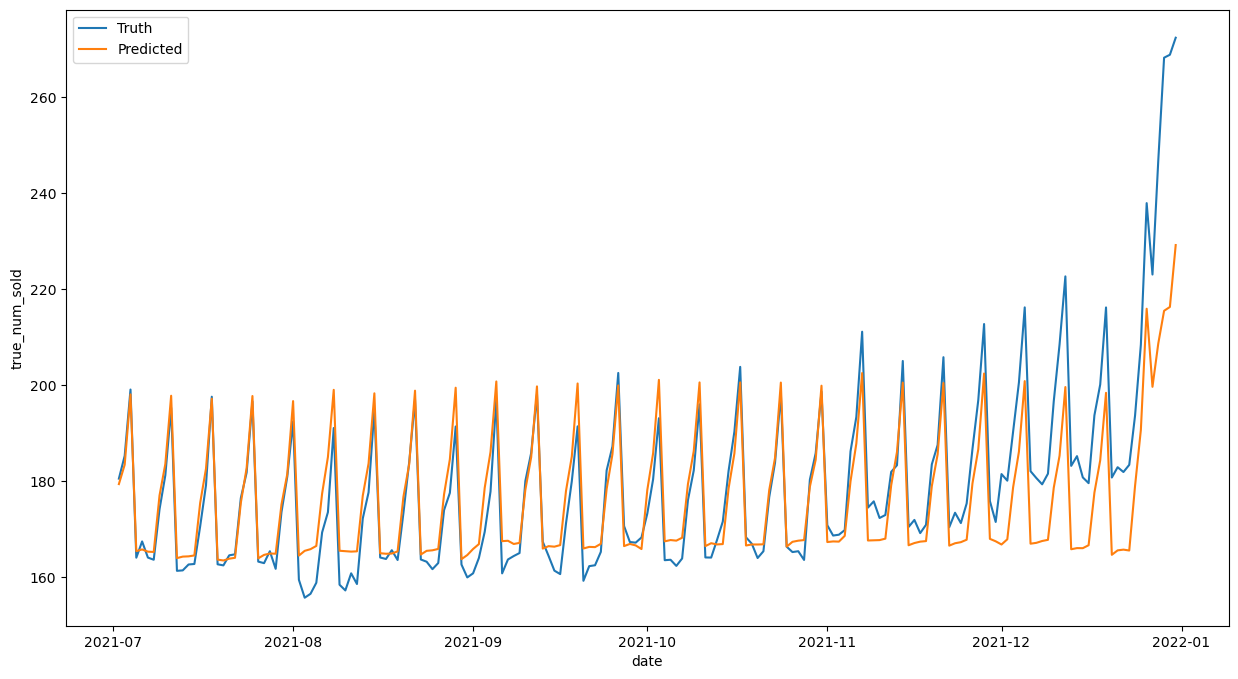

In [31]:
plt.figure(figsize=(15,8))
sns.lineplot(x='date', y='true_num_sold', data=ens, ci=None, label='Truth')
sns.lineplot(x='date', y='predicted_num_sold', data=ens, ci=None, label='Predicted')
plt.legend()

# Final Prediction on whole data

In [32]:
no_lags = 7
train = clreate_lags_by_group(data, lags=no_lags)
train = prepare_data(train, train_flag=True)
train_x = train.drop(['num_sold'], axis=1)
train_y = train['num_sold']

In [33]:
# Create the XGBRegressor model
xgb_model_lagged_final = XGBRegressor()

# Fit the model to the data
xgb_model_lagged_final.fit(train_x.values, train_y.values)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [35]:
final_xgb_submission = predict(xgb_model_lagged_final, test, pd.concat([train_x,train_y],axis=1),train_x.columns, no_lags)

(365, 2)(730, 2)(1095, 2)(1460, 2)(1825, 2)(2190, 2)(2555, 2)(2920, 2)(3285, 2)(3650, 2)(4015, 2)(4380, 2)(4745, 2)(5110, 2)(5475, 2)(5840, 2)(6205, 2)(6570, 2)(6935, 2)(7300, 2)(7665, 2)(8030, 2)(8395, 2)(8760, 2)(9125, 2)(9490, 2)(9855, 2)(10220, 2)(10585, 2)(10950, 2)(11315, 2)(11680, 2)(12045, 2)(12410, 2)(12775, 2)(13140, 2)(13505, 2)(13870, 2)(14235, 2)(14600, 2)(14965, 2)(15330, 2)(15695, 2)(16060, 2)(16425, 2)(16790, 2)(17155, 2)(17520, 2)(17885, 2)(18250, 2)(18615, 2)(18980, 2)(19345, 2)(19710, 2)(20075, 2)(20440, 2)(20805, 2)(21170, 2)(21535, 2)(21900, 2)(22265, 2)(22630, 2)(22995, 2)(23360, 2)(23725, 2)(24090, 2)(24455, 2)(24820, 2)(25185, 2)(25550, 2)(25915, 2)(26280, 2)(26645, 2)(27010, 2)(27375, 2)

In [36]:
final_xgb_submission_merged = test.merge(final_xgb_submission, on='id', how='inner')
final_xgb_submission_merged = final_xgb_submission_merged[['id', 'predicted_num_sold']]
final_xgb_submission_merged['num_sold'] = final_xgb_submission_merged['predicted_num_sold']

In [45]:
final_xgb_submission_merged.head(10)

id  predicted_num_sold   num_sold
0  136950           43.130020  43.130020
1  136951           43.734253  43.734253
2  136952            6.690915   6.690915
3  136953           43.229710  43.229710
4  136954           32.668930  32.668930
5  136955           64.315468  64.315468
6  136956           72.804237  72.804237
7  136957           10.030867  10.030867
8  136958           64.063805  64.063805
9  136959           50.956593  50.956593

In [46]:
final_xgb_submission_merged = final_xgb_submission_merged[['id', 'num_sold']]
final_xgb_submission_merged.to_csv("submission.csv", index=False)

In [38]:
from catboost import CatBoostRegressor
# Create the XGBRegressor model
final_cat_model_lagged = CatBoostRegressor(silent=True, depth= 7, iterations= 3000, learning_rate=.009)

# Fit the model to the data
final_cat_model_lagged.fit(train_x.values, train_y.values)

final_cat_boost_submission = predict(final_cat_model_lagged, test, pd.concat([train_x,train_y],axis=1),train_x.columns, no_lags)

(365, 2)(730, 2)(1095, 2)(1460, 2)(1825, 2)(2190, 2)(2555, 2)(2920, 2)(3285, 2)(3650, 2)(4015, 2)(4380, 2)(4745, 2)(5110, 2)(5475, 2)(5840, 2)(6205, 2)(6570, 2)(6935, 2)(7300, 2)(7665, 2)(8030, 2)(8395, 2)(8760, 2)(9125, 2)(9490, 2)(9855, 2)(10220, 2)(10585, 2)(10950, 2)(11315, 2)(11680, 2)(12045, 2)(12410, 2)(12775, 2)(13140, 2)(13505, 2)(13870, 2)(14235, 2)(14600, 2)(14965, 2)(15330, 2)(15695, 2)(16060, 2)(16425, 2)(16790, 2)(17155, 2)(17520, 2)(17885, 2)(18250, 2)(18615, 2)(18980, 2)(19345, 2)(19710, 2)(20075, 2)(20440, 2)(20805, 2)(21170, 2)(21535, 2)(21900, 2)(22265, 2)(22630, 2)(22995, 2)(23360, 2)(23725, 2)(24090, 2)(24455, 2)(24820, 2)(25185, 2)(25550, 2)(25915, 2)(26280, 2)(26645, 2)(27010, 2)(27375, 2)

In [39]:
final_cat_boost_submission_merged = test.merge(final_cat_boost_submission, on='id', how='inner')
final_cat_boost_submission_merged.head()

id       date    country         store  \
0  136950 2022-01-01  Argentina  Kaggle Learn   
1  136951 2022-01-01  Argentina  Kaggle Learn   
2  136952 2022-01-01  Argentina  Kaggle Learn   
3  136953 2022-01-01  Argentina  Kaggle Learn   
4  136954 2022-01-01  Argentina  Kaggle Learn   

                                          product  predicted_num_sold  
0               Using LLMs to Improve Your Coding           42.379379  
1                   Using LLMs to Train More LLMs           44.538264  
2  Using LLMs to Win Friends and Influence People            8.450025  
3      Using LLMs to Win More Kaggle Competitions           41.338376  
4                      Using LLMs to Write Better           33.927232

In [40]:
final_cat_boost_submission_merged['num_sold'] = final_cat_boost_submission_merged['predicted_num_sold']

In [42]:
final_cat_boost_submission_merged = final_cat_boost_submission_merged[['id', 'num_sold']]
final_cat_boost_submission_merged.to_csv('submission.csv', index=False)

# XGBoost +  CatBoost Final Submission

In [ ]:
ens = pd.DataFrame()
ens['id'] = final_cat_boost_submission_merged['id']
ens['num_sold'] = (final_xgb_submission_merged['predicted_num_sold'] + final_cat_boost_submission_merged['predicted_num_sold'])/2


In [ ]:
ens.to_csv('submission.csv', index=False)

# Future plan is to use ARIMA, SARIMAX and FB Prophet, but for now above is the final submitted file. Ignore following code

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
int_data = data[(data['country']=='Argentina') & (data['store']=='Kaggle Learn') &  (data['product']=='Using LLMs to Improve Your Coding')]['num_sold']

adfuller(int_data)

int_data = data[(data['country']=='Argentina') & (data['store']=='Kaggle Learn') &  (data['product']=='Using LLMs to Improve Your Coding')]['num_sold'].diff().dropna()
fig,ax = plt.subplots(1,2, figsize=(15,5))
plot_acf(int_data, ax=ax[0], lags=80)
plot_pacf(int_data, ax=ax[1], lags=80)

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(train.index,train)
plt.plot(test.index,test)
#plt.plot(model_fit.fittedvalues.index,model_fit.fittedvalues)

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(train, lags=365)
model_fit = model.fit()

In [ ]:
test.index[0]

In [ ]:
import datetime
start = test.index[0]
end = test.index[-1]

print(start, end)
predicted = model_fit.predict(start,end)

In [ ]:
start_week = datetime.datetime.strptime('2017-01-01','%Y-%m-%d')
end_week = datetime.datetime.strptime('2017-06-30','%Y-%m-%d')
print(train[start_week:end_week].mean())

start_week = datetime.datetime.strptime('2018-01-01','%Y-%m-%d')
end_week = datetime.datetime.strptime('2018-06-30','%Y-%m-%d')
print(train[start_week:end_week].mean())

start_week = datetime.datetime.strptime('2019-01-01','%Y-%m-%d')
end_week = datetime.datetime.strptime('2019-06-30','%Y-%m-%d')
print(train[start_week:end_week].mean())

start_week = datetime.datetime.strptime('2020-01-01','%Y-%m-%d')
end_week = datetime.datetime.strptime('2020-06-30','%Y-%m-%d')
print(train[start_week:end_week].mean())

start_week = datetime.datetime.strptime('2021-01-01','%Y-%m-%d')
end_week = datetime.datetime.strptime('2021-06-30','%Y-%m-%d')
print(test[start_week:end_week].mean())

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(train.index,train)
plt.plot(test.index,test)
plt.plot(model_fit.fittedvalues.index,model_fit.fittedvalues)
plt.plot(predicted)

In [ ]:
from statsmodels.tsa.stattools import adfuller
int_data = data[(data['country']=='Argentina') & (data['store']=='Kaggle Learn') &  (data['product']=='Using LLMs to Improve Your Coding')]['num_sold']

adfuller(int_data)

In [ ]:
int_data = data[(data['country']=='Argentina') & (data['store']=='Kaggle Learn') &  (data['product']=='Using LLMs to Improve Your Coding')]['num_sold'].diff().dropna()
fig,ax = plt.subplots(1,2, figsize=(15,5))
plot_acf(int_data, ax=ax[0], lags=80)
plot_pacf(int_data, ax=ax[1], lags=80)


In [ ]:
int_data

In [ ]:
train_limit = int(len(int_data)*.90)
#train_limit = -30
train_data = int_data.set_index('date')['num_sold'][:train_limit]
test_data = int_data.set_index('date')['num_sold'][train_limit:]

In [ ]:
test_data

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

# Fit an AR model
model = AutoReg(train_data, lags=7)
model_fit = model.fit()

# Print the model coefficients
print(model_fit.params)

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(train_data.index,train_data)
plt.plot(test_data.index,test_data)
plt.plot(model_fit.fittedvalues.index,model_fit.fittedvalues)

In [ ]:
import datetime
# start = datetime.datetime.strptime(test_data.index[0],'%Y-%m-%d')
# end = datetime.datetime.strptime(test_data.index[-1],'%Y-%m-%d')


start = test_data.index[0]
end = test_data.index[-1]

print(start, end)
predicted = model_fit.predict(start,end)

In [ ]:
len(predicted), len(test_data)

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(test_data.values)
plt.plot(predicted.values)
plt.legend()

In [ ]:
!pip install pmdarima

In [ ]:
from pmdarima import auto_arima
auto_model = auto_arima(train_data,start_p=14, d=0, start_q=12, max_p=60, max_d=2, max_q=30,
                        seasonal=False,stationary=True,trace=True,scoring ='mse',maxiter=100)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model_arima_best = ARIMA(train_data,order = (15,1,1)).fit()

In [ ]:
from datetime import datetime
# make prediction
start_date = test_data.index[1]
end_date = test_data.index[-1]
prediction_arima_best = model_arima_best.predict(start_date,end_date)# stationary data

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(test_data.values)
plt.plot(prediction_arima_best.values)
plt.legend()

In [ ]:
import statsmodels.api as sm

In [ ]:
sarime_model=sm.tsa.statespace.SARIMAX(train_data,order=(7, 1, 1),seasonal_order=(7,1,1,15))
results=sarime_model.fit()

In [ ]:
start_date = test_data.index[1]
end_date = test_data.index[-1]
prediction_sarime = results.predict(start_date,end_date)# stationary data

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(test_data.values)
plt.plot(prediction_sarime.values)
plt.legend()